### Libraries

In [23]:
import sys
import os
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import numpy as np
import pandas as pd
import plotly_express as px
from datetime import datetime, timedelta 
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import keras

from functions_laura.Data_processing import add_seasonal
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization, LSTM, TimeDistributed, Input
import mlflow
import mlflow.keras


### MLFlow settings

Setup MLflow:

In [24]:
import os
import mlflow

# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_name = f"FuelProphet_CNN_Testing-cnn-lstm-1-seasonality-Loop_{timestamp}"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")

mlflow.keras.autolog(log_models=False)

Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


# Deep Neural Networks for Time Series Analysis

We can use Deep Neural Networks to analyze time series. There are several options how to do this. 
We can use 
* convolutional neural networks (CNN)
* long-term short memory (LSTM)

or even hybrid models that combine CNN and LSTM layers.

Additionally to the timeseries data that we put in to analyze, we can add features to improve model performance.

### potential features
In the case of gas stations, we can think of the following features that potentially have an effect:
* Day of the week
* Station Type (LKW, Automat, Autobahn, rest stop)
* Oil price
* Exchange Rate
* Location
* Density
* Brand
* Dominant Gas station
* Opening times
* Mean price in radius or city

First, we load the data and clean it a little bit:

# Loading train/test data

In [25]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_2/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_2/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_2/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_2/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_2/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_2/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_2/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_2/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_2/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_2/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_2/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_2/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_2/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_2/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_2/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_2/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_2/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_2/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_2/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_2/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_2/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_2/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_2/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_2/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_2/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_2/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_2/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_2/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_2/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_2/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_2/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_2/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_2/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_2/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_2/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_2/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_2/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_2/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_2/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_2/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_2/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_2/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_2/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_2/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_2/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_2/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_2/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_2/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_2/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_2/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_2/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_2/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_2/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_2/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_2/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_2/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_2/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_2/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_2/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_2/test_30.parquet')

# Rename date to datetime

In [26]:
# Train
df01_train.rename(columns={"date": "datetime"}, inplace=True)
df02_train.rename(columns={"date": "datetime"}, inplace=True)
df03_train.rename(columns={"date": "datetime"}, inplace=True)
df04_train.rename(columns={"date": "datetime"}, inplace=True)
df05_train.rename(columns={"date": "datetime"}, inplace=True)
df06_train.rename(columns={"date": "datetime"}, inplace=True)
df07_train.rename(columns={"date": "datetime"}, inplace=True)
df08_train.rename(columns={"date": "datetime"}, inplace=True)
df09_train.rename(columns={"date": "datetime"}, inplace=True)
df10_train.rename(columns={"date": "datetime"}, inplace=True)
df11_train.rename(columns={"date": "datetime"}, inplace=True)
df12_train.rename(columns={"date": "datetime"}, inplace=True)
df13_train.rename(columns={"date": "datetime"}, inplace=True)
df14_train.rename(columns={"date": "datetime"}, inplace=True)
df15_train.rename(columns={"date": "datetime"}, inplace=True)
df16_train.rename(columns={"date": "datetime"}, inplace=True)
df17_train.rename(columns={"date": "datetime"}, inplace=True)
df18_train.rename(columns={"date": "datetime"}, inplace=True)
df19_train.rename(columns={"date": "datetime"}, inplace=True)
df20_train.rename(columns={"date": "datetime"}, inplace=True)
df21_train.rename(columns={"date": "datetime"}, inplace=True)
df22_train.rename(columns={"date": "datetime"}, inplace=True)
df23_train.rename(columns={"date": "datetime"}, inplace=True)
df24_train.rename(columns={"date": "datetime"}, inplace=True)
df25_train.rename(columns={"date": "datetime"}, inplace=True)
df26_train.rename(columns={"date": "datetime"}, inplace=True)
df27_train.rename(columns={"date": "datetime"}, inplace=True)
df28_train.rename(columns={"date": "datetime"}, inplace=True)
df29_train.rename(columns={"date": "datetime"}, inplace=True)
df30_train.rename(columns={"date": "datetime"}, inplace=True)


# Test
df01_test.rename(columns={"date": "datetime"}, inplace=True)
df02_test.rename(columns={"date": "datetime"}, inplace=True) 
df03_test.rename(columns={"date": "datetime"}, inplace=True) 
df04_test.rename(columns={"date": "datetime"}, inplace=True) 
df05_test.rename(columns={"date": "datetime"}, inplace=True) 
df06_test.rename(columns={"date": "datetime"}, inplace=True) 
df07_test.rename(columns={"date": "datetime"}, inplace=True) 
df08_test.rename(columns={"date": "datetime"}, inplace=True) 
df09_test.rename(columns={"date": "datetime"}, inplace=True) 
df10_test.rename(columns={"date": "datetime"}, inplace=True) 
df11_test.rename(columns={"date": "datetime"}, inplace=True) 
df12_test.rename(columns={"date": "datetime"}, inplace=True) 
df13_test.rename(columns={"date": "datetime"}, inplace=True) 
df14_test.rename(columns={"date": "datetime"}, inplace=True) 
df15_test.rename(columns={"date": "datetime"}, inplace=True) 
df16_test.rename(columns={"date": "datetime"}, inplace=True) 
df17_test.rename(columns={"date": "datetime"}, inplace=True) 
df18_test.rename(columns={"date": "datetime"}, inplace=True) 
df19_test.rename(columns={"date": "datetime"}, inplace=True) 
df20_test.rename(columns={"date": "datetime"}, inplace=True) 
df21_test.rename(columns={"date": "datetime"}, inplace=True) 
df22_test.rename(columns={"date": "datetime"}, inplace=True) 
df23_test.rename(columns={"date": "datetime"}, inplace=True) 
df24_test.rename(columns={"date": "datetime"}, inplace=True) 
df25_test.rename(columns={"date": "datetime"}, inplace=True) 
df26_test.rename(columns={"date": "datetime"}, inplace=True) 
df27_test.rename(columns={"date": "datetime"}, inplace=True) 
df28_test.rename(columns={"date": "datetime"}, inplace=True) 
df29_test.rename(columns={"date": "datetime"}, inplace=True) 
df30_test.rename(columns={"date": "datetime"}, inplace=True) 

### Data processing (without feature engineering)

We split the data into train, test and validation:

[-------- Train --------][--- Validation ---][--- Test ---]


It is important to process the data correctly.


1) choose the data of one gas station (using the uuid)
2) define the training data and the test data to avoid data leakage
3) define your sliding window 
4) Create sequences of your train data
5) Create sequences of your test data defining input and output 


### The sliding window to prepare sequential data
so it can fit into my model. We are using a sliding window of 288 (1 day). After every 288 e5 prices, we look at the price that comes after it. 
$X$ is an array consisting of all the sequences, so it has 288 columns.
$y$ is a 1D array of all these values that come after the 288 (= the next step)

$X$ and $y$ have 288 less rows than the original df, because:

| i    | Input `X[i]` (rows used) | Target `y[i]` |
| ---- | ------------------------ | ------------- |
| 0    | rows 0 to 287            | row 288, E5   |
| 1    | rows 1 to 288            | row 289, E5   |
| 2    | rows 2 to 289            | row 290, E5   |
| ...  | ...                      | ...           |
| 9711 | rows 9711 to 9998        | row 9999, E5  |

# Functions script

In [27]:
def create_sequences(
        data, 
        window_size, 
        target_col_index):
    """Create sequences for time series prediction.
    
    Args:
        data: Scaled input data with shape (samples, features)
        window_size: Number of time steps to look back
        target_col_index: Index of the target column to predict
        
    Returns:
        X: Input sequences with shape (samples, window_size, features)
        y: Target values with shape (samples,)
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        # Get sequence of all features
        sequence = data[i:(i + window_size)]
        X.append(sequence)
        # Get next value of target feature
        target = data[i + window_size, target_col_index]
        y.append(target)
    return np.array(X), np.array(y)
##################################################################
def preprocess(
        df_train, df_test,
        start_forecast=None,
        fuel='e5',
        output_days=1,
        verbose=True):
    
    # Filter and resample
    df_train = add_seasonal(df_train)
    df_test = add_seasonal(df_test)

    # Split data
    # Find the middle point of df_test
    middle_idx = len(df_train) // 2
    
    test_df = df_test
    train_df = df_train[:middle_idx].copy()  # First half
    val_df = df_train[middle_idx:-288].copy()  # Second half
    forecast_df = df_train[-288:].copy()

    # set datetime index
    train_df.set_index('datetime', inplace=True)
    val_df.set_index('datetime', inplace=True)
    test_df.set_index('datetime', inplace=True)
    forecast_df.set_index('datetime', inplace=True)

    # Scaling
    scaler = MinMaxScaler()
    features = ['seasonal_component', fuel]
    scaler.fit(train_df[features])

    scaled_train = scaler.transform(train_df[features])
    scaled_val = scaler.transform(val_df[features])
    scaled_forecast = scaler.transform(forecast_df[features])

    # Sequence generation
    window_size = 288
    target_col_index = 1

    X, y = create_sequences(scaled_train, window_size, target_col_index)
    X_val, y_val = create_sequences(scaled_val, window_size, target_col_index)

    # Forecast setup
    X_forecast = scaled_forecast.reshape(1, window_size, 2)


    ### === Verbose plots === ###
    if verbose:
        # Time series overview
        plt.figure(figsize=(10,6))
        plt.plot(train_df.index, train_df[fuel], label='Train', drawstyle='steps-post')
        plt.plot(val_df.index, val_df[fuel], label='Validation', drawstyle='steps-post')
        plt.plot(test_df.index, test_df[fuel], label='Test', drawstyle='steps-post')
        plt.title("Train, Validation, and Test Data")
        plt.xlabel("Date")
        plt.ylabel(f"{fuel} Price")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("Data_overview.png")
        mlflow.log_artifact("Data_overview.png")
        plt.show()

        # KDE for distribution comparison
        kde_train = gaussian_kde(train_df[fuel].dropna())
        kde_val = gaussian_kde(val_df[fuel].dropna())
        kde_test = gaussian_kde(test_df[fuel].dropna())

        x_vals = np.linspace(
            min(train_df[fuel].min(), val_df[fuel].min(), test_df[fuel].min()),
            max(train_df[fuel].max(), val_df[fuel].max(), test_df[fuel].max()), 1000
        )

        plt.figure(figsize=(10,4))
        plt.plot(x_vals, kde_train(x_vals), label='Train', color='blue')
        plt.plot(x_vals, kde_val(x_vals), label='Validation', color='green')
        plt.plot(x_vals, kde_test(x_vals), label='Test', color='orange')
        plt.title(f"KDE of {fuel} in Train, Validation, Test")
        plt.xlabel(f"{fuel} Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.savefig("KDE.png")
        mlflow.log_artifact("KDE.png")
        plt.show()

        print(f"Train shape: {X.shape}  | Validation shape: {X_val.shape}")
        print(f"Forecast setup from {test_df.index.min()} to {start_forecast}, to predict {output_days} day(s)")
        print(f"Test set range: {test_df.index.min()} to {test_df.index.max()}")

    return X, y, X_val, y_val, X_forecast, scaler, scaled_train, val_df, test_df

#########################################################################################

def build_model(model_type, params, input_shape=(288, 2)):
    model = Sequential()
    if model_type == 'cnn_small':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) # 1-dimensional deconvolution
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        ########################################################################
    elif model_type == 'cnn_big':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.2))
        ########################################################################
    elif model_type == 'cnn_lstm_1':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(params['lstm_units'], return_sequences=False))
        ########################################################################
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mse')

    return model

########################################################################

def train_model_with_mlflow(X, y, X_val, y_val, model_type, params, days_output=None, input_shape=(288, 2)):
    # Log parameters manually (optional if autolog is on)
    mlflow.log_param("days_output", days_output)
    mlflow.set_tag("dataset", f'{dataset_name}')
    mlflow.set_tag("model_type", model_type)
    
    model = build_model(model_type=model_type, params=params, input_shape=input_shape)
    # Train model
    history = model.fit(
        X, y,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=1
    )
    # Log final metrics manually if you want more control
    final_val_loss = history.history['val_loss'][-1]
    mlflow.log_metric("final_val_loss", final_val_loss)
    
    # Optionally log a plot
    plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss over Epochs")
    plt.legend()
    plt.savefig("loss_plot.png")
    mlflow.log_artifact("loss_plot.png")
    
    model_path = 'model.keras'
    keras.saving.save_model(model, model_path, save_format="keras")
    mlflow.log_artifact(model_path)

    return model, history

########################################################################

# Helper Functions

def inverse_scale(preds, original_data, target_index, scaler):
    """Inverse scale predictions by placing them into a dummy array 
    and applying scaler.inverse_transform."""
    dummy = np.zeros((len(preds), original_data.shape[1]))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

# Function that forecasts and prints the forecast
def forecasting(
        X_forecast,
        scaled_train,
        scaler,
        forecast_start_date=None,
        fuel='e5',
        model = None,
        output_days=7
    ):
    '''
    _summary_

    Args:
        X_forecast (np.array): Output from processing function
        scaled_train (np.array): Output from processing function
        scaler (fitted MinMax Scaler): Output from processing function
        start_forecast (string): date of forecast start already defied in the processing function
        fuel (str, optional): Fuel type, 'es', 'e10' or 'diesel'. Defaults to 'e5'.
    '''
    
    steps_per_day = 288  # 5-minute intervals per day
    total_steps = steps_per_day * output_days
    
    # Initialize array for predictions
    predictions = []
    
    # Get initial window
    current_window = X_forecast.copy()  # shape: (1, 288, 2)

    # Get initial seasonal pattern for the forecast period
    initial_seasonal = current_window[0, :, 0]  # Get seasonal component
    seasonal_pattern = np.tile(initial_seasonal, (total_steps // 288) + 1)[:total_steps]
    
    # Make recursive predictions
    for step in range(total_steps):
        # Make single prediction
        next_pred = model.predict(current_window, verbose=0)[0, 0]
        predictions.append(next_pred)
        
        # Update window by removing oldest value and adding prediction
        current_window = np.roll(current_window, -1, axis=1)
        # Update both features
        current_window[0, -1, 0] = seasonal_pattern[step]  # Update seasonal component
        current_window[0, -1, 1] = next_pred  # Update e5 price
    
    # Convert predictions to array and reshape
    predictions = np.array(predictions).reshape(-1, 1)
    
    # Scale back to original range
    predictions_unscaled = inverse_scale(predictions, scaled_train, target_index=1, scaler=scaler)
    
    # Create datetime index for the forecast period
    time_index = pd.date_range(
        start=forecast_start_date,
        periods=total_steps,
        freq='5min'
    )
    
     #Return as DataFrame
    return pd.DataFrame({
        'datetime': time_index,
        'e5': predictions_unscaled.flatten()
    })

# Function to plot
def plot_forecast(df_train, df_test, station_uuid=None, df_train_prediction=None, 
                 df_test_prediction=None, train_dates=None, test_dates=None, 
                 train_dates_plot=None, test_dates_plot=None):
    
    plt.figure(figsize=(15, 6))
    
    # Convert string dates to timestamps if they aren't already
    if train_dates and isinstance(train_dates[0], str):
        train_dates = (pd.to_datetime(train_dates[0]), pd.to_datetime(train_dates[1]))
    if test_dates and isinstance(test_dates[0], str):
        test_dates = (pd.to_datetime(test_dates[0]), pd.to_datetime(test_dates[1]))

    train_mask = (df_train['datetime'] >= train_dates[0]) & (df_train['datetime'] <= train_dates[1]) if train_dates else slice(None)
    test_mask = (df_test['datetime'] >= test_dates[0]) & (df_test['datetime'] <= test_dates[1]) if test_dates else slice(None)
    
    if station_uuid is not None:
        df_train = df_train[df_train['station_uuid'] == station_uuid]
        df_test = df_test[df_test['station_uuid'] == station_uuid]

    if df_train_prediction is not None:
        df_train_prediction = df_train_prediction[(df_train_prediction['datetime'] >= train_dates[0]) & (df_train_prediction['datetime'] <= train_dates[1])]
        #plt.plot(df_train_prediction['datetime'], df_train_prediction['e5'], label='Train Prediction', color='green', linestyle='--', linewidth=2, drawstyle='steps-post')

    if df_test_prediction is not None:
        df_test_prediction = df_test_prediction[(df_test_prediction['datetime'] >= test_dates[0]) & (df_test_prediction['datetime'] <= test_dates[1])]
        plt.plot(df_test_prediction['datetime'], df_test_prediction['e5'], label='Test Prediction', color='red', linestyle='--', linewidth=2, drawstyle='steps-post')

        # --- Error Calculation and Display ---
        df_merged = df_test.merge(df_test_prediction, on='datetime', suffixes=('_actual', '_pred'))
        df_merged = df_merged.sort_values('datetime').reset_index(drop=True)

        mae_dict = {}
        rmse_dict = {}
        r2_dict = {}

        for i, days in enumerate([1, 3, 7]):
            time_cutoff = df_merged['datetime'].min() + timedelta(days=days)
            df_subset = df_merged[df_merged['datetime'] < time_cutoff]

            if not df_subset.empty:
                mae = mean_absolute_error(df_subset['e5_actual'], df_subset['e5_pred'])
                rmse = np.sqrt(mean_squared_error(df_subset['e5_actual'], df_subset['e5_pred']))
                r2 = r2_score(df_subset['e5_actual'], df_subset['e5_pred'])
                mae_dict[days] = mae
                rmse_dict[days] = rmse
                r2_dict[days] = r2

                print(f"{days}-Day MAE in cent: {mae *100:.4f}")
                print(f"{days}-Day RMSE in cent: {rmse *100:.4f}")
                print(f"{days}-Day r2-score: {r2:.4f}")
                #plt.text(0.01, 0.95 - 0.05 * i, f'{days}-day MAE in cent: {mae*100:.4f}', 
                         #transform=plt.gca().transAxes, fontsize=12, 
                         #bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.7))
    
    plt.plot(df_train.loc[train_mask, 'datetime'], df_train.loc[train_mask, 'e5'], label='Train Actual', color='blue', linewidth=2, drawstyle='steps-post', alpha=0.7)
    plt.plot(df_test.loc[test_mask, 'datetime'], df_test.loc[test_mask, 'e5'], label='Test Actual', color='orange', linewidth=2, drawstyle='steps-post', alpha=0.7)
    
    plt.legend(fontsize=12, title_fontsize=14, loc='upper left', frameon=True, fancybox=True, shadow=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('E5 Price: Actual vs Prediction', fontsize=16)
    plt.xlabel('date', fontsize=14)
    plt.ylabel('E5 price', fontsize=14)
    plt.tight_layout(pad=2)
    plt.gca().set_facecolor('#f7f7fa')
    plt.gcf().patch.set_facecolor('#eaeaf2')
    plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7)
    plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7)
    plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))
    plt.savefig("prediction.png")
    plt.show()

    # After the loop, you have:
    mae_1_day = mae_dict.get(1)
    mae_3_day = mae_dict.get(3)
    mae_7_day = mae_dict.get(7)

    rmse_1_day = rmse_dict.get(1)
    rmse_3_day = rmse_dict.get(3)
    rmse_7_day = rmse_dict.get(7)

    r2_1_day = r2_dict.get(1)
    r2_3_day = r2_dict.get(3)
    r2_7_day = r2_dict.get(7)

    return mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day




# Start of the analysis

In [28]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}


Processing dataset: df01


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - loss: 0.0380 - val_loss: 0.0042
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 7.6450
1-Day RMSE in cent: 8.0387
1-Day r2-score: -11.1800
3-Day MAE in cent: 8.0632
3-Day RMSE in cent: 8.3967
3-Day r2-score: -12.9301
7-Day MAE in cent: 7.7327
7-Day RMSE in cent: 8.0283
7-Day r2-score: -9.1750


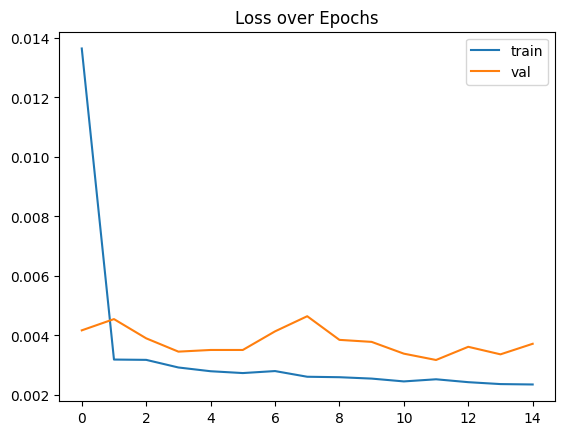

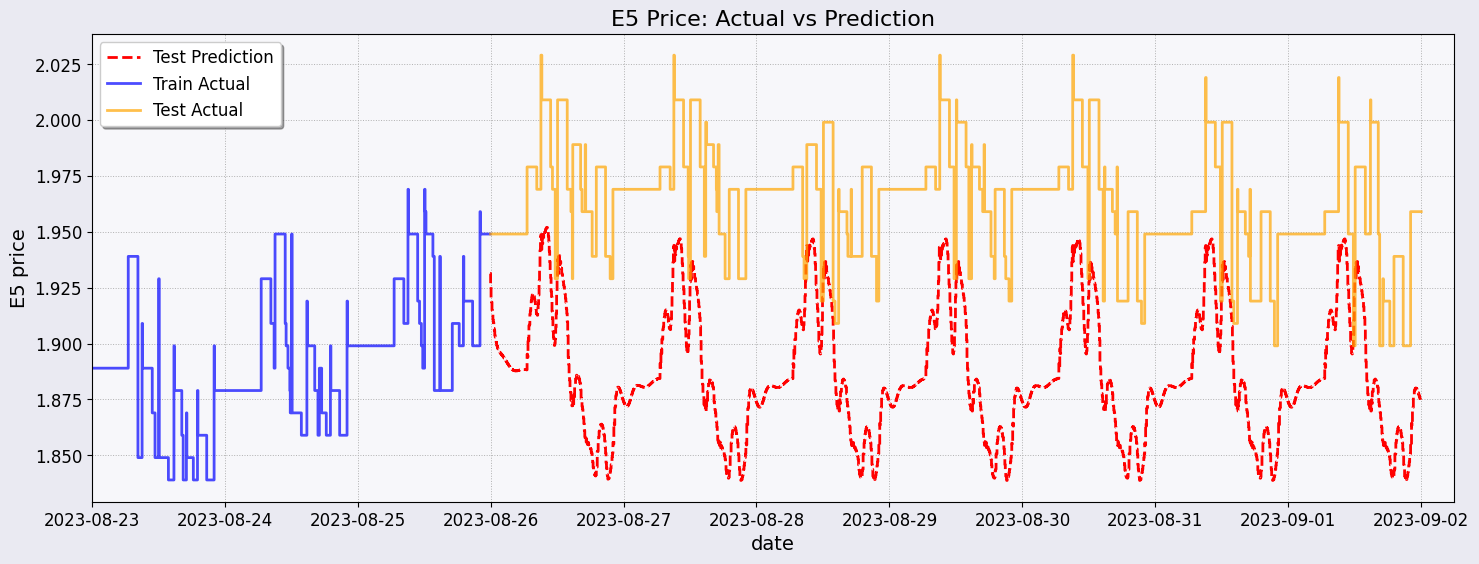

Successfully processed df01

Processing dataset: df02


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0321 - val_loss: 0.0071
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 2.4658
1-Day RMSE in cent: 3.0216
1-Day r2-score: -0.0634
3-Day MAE in cent: 2.4198
3-Day RMSE in cent: 3.2434
3-Day r2-score: -0.1277
7-Day MAE in cent: 2.7122
7-Day RMSE in cent: 3.5581
7-Day r2-score: -0.1856


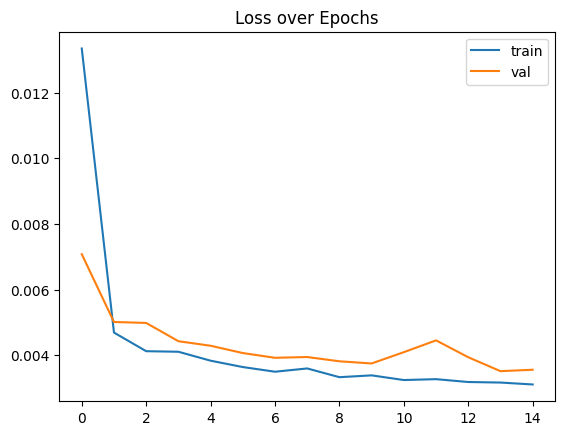

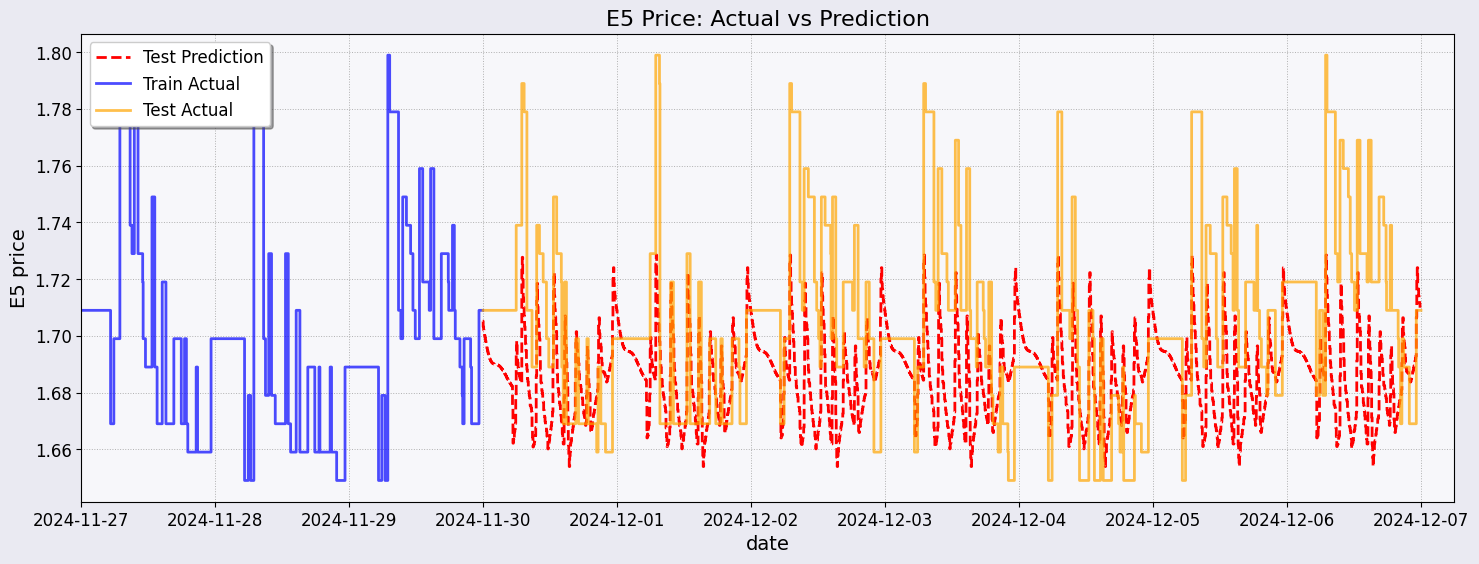

Successfully processed df02

Processing dataset: df03


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0112 - val_loss: 0.0030
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 8.9411
1-Day RMSE in cent: 9.9725
1-Day r2-score: -10.1038
3-Day MAE in cent: 10.9032
3-Day RMSE in cent: 11.6164
3-Day r2-score: -11.9812
7-Day MAE in cent: 9.9813
7-Day RMSE in cent: 10.7026
7-Day r2-score: -6.8962


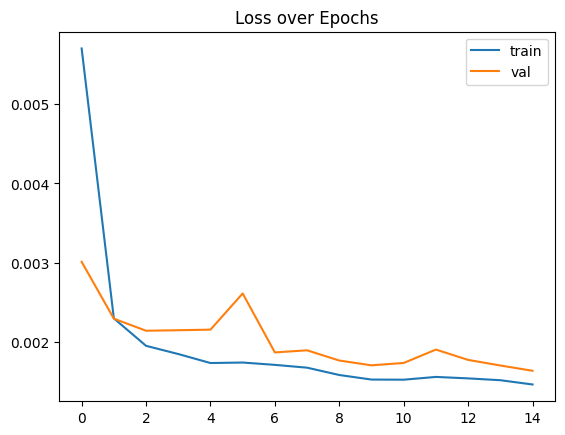

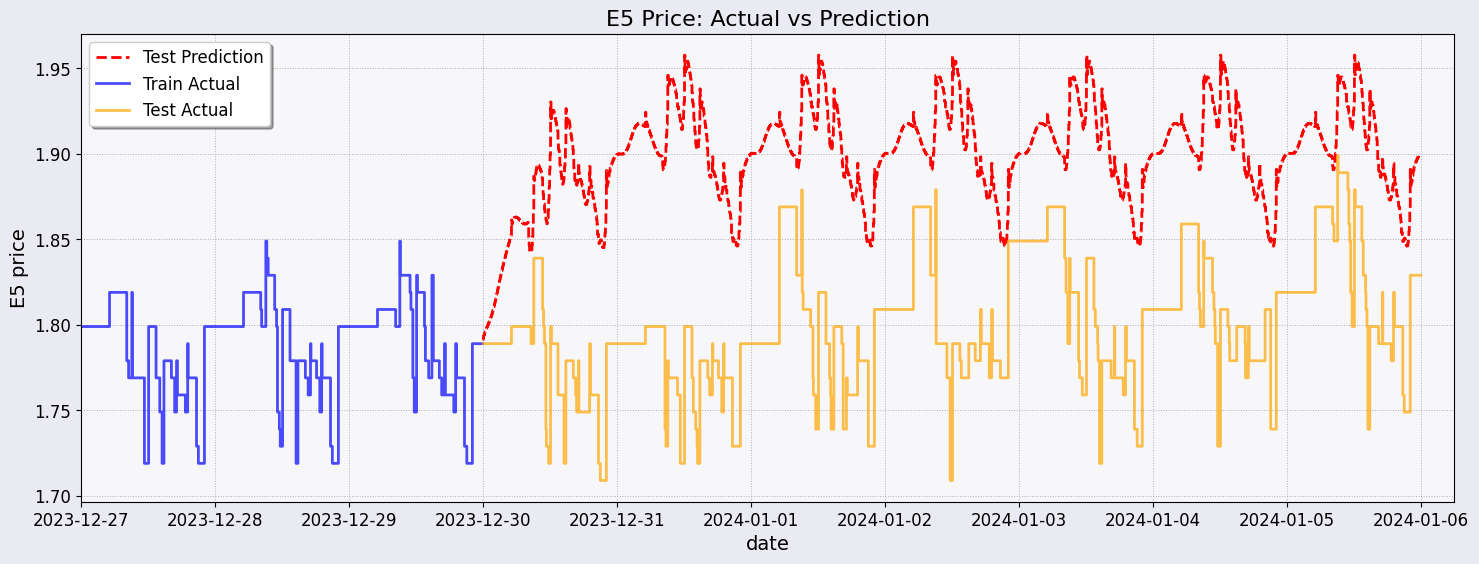

Successfully processed df03

Processing dataset: df04


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0197 - val_loss: 0.0049
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - loss: 0.0029 - val_loss: 0.0039
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 2.3118
1-Day RMSE in cent: 2.8172
1-Day r2-score: -0.2437
3-Day MAE in cent: 2.2198
3-Day RMSE in cent: 2.6942
3-Day r2-score: 0.0880
7-Day MAE in cent: 2.7566
7-Day RMSE in cent: 3.2592
7-Day r2-score: -0.1014


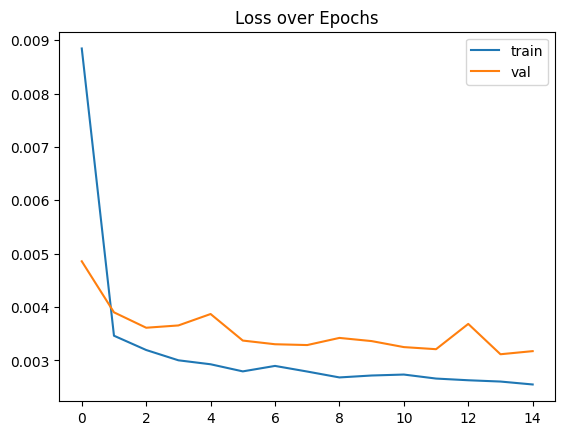

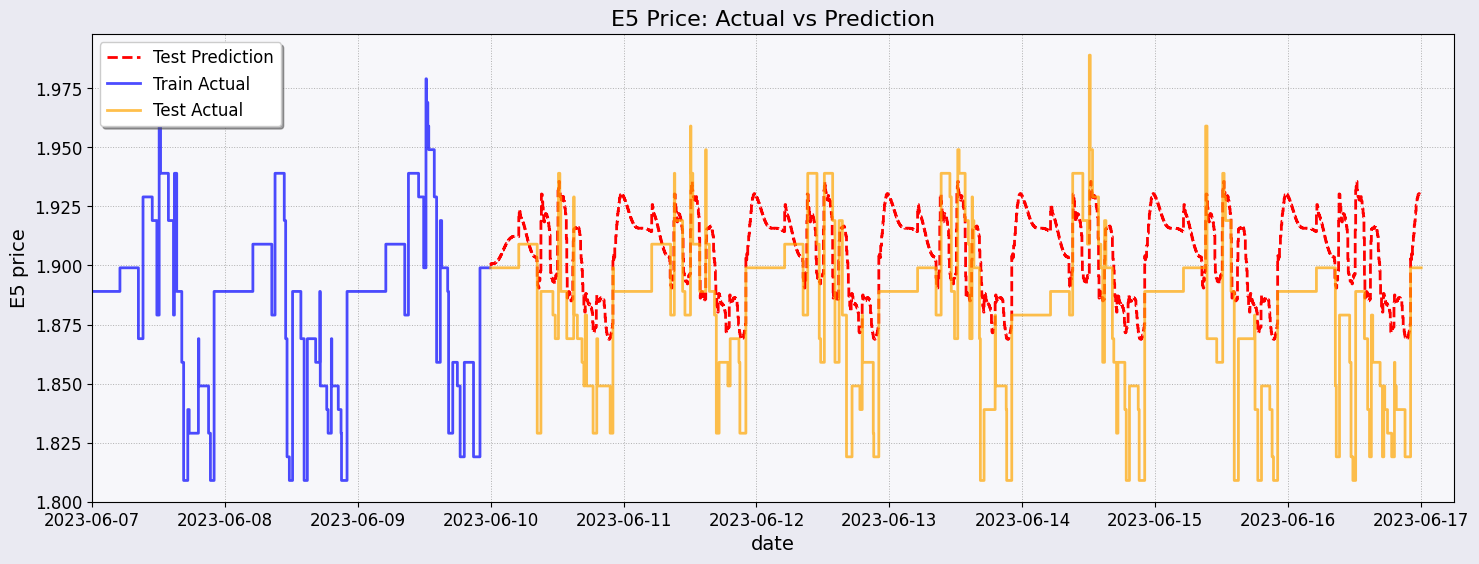

Successfully processed df04

Processing dataset: df05


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0245 - val_loss: 0.0034
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 

1-Day MAE in cent: 1.9359
1-Day RMSE in cent: 2.7807
1-Day r2-score: -0.0526
3-Day MAE in cent: 4.9267
3-Day RMSE in cent: 6.7361
3-Day r2-score: -1.0511
7-Day MAE in cent: 3.7804
7-Day RMSE in cent: 5.2853
7-Day r2-score: -0.7441


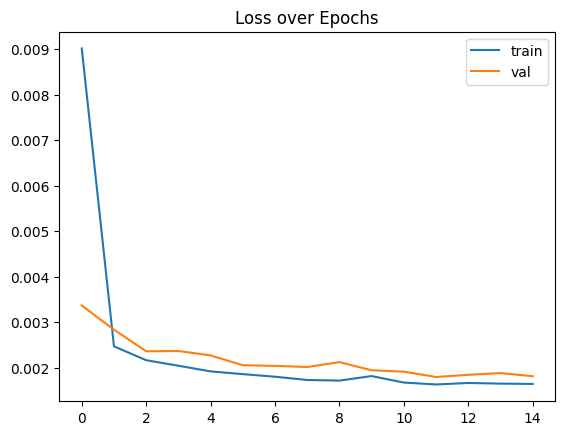

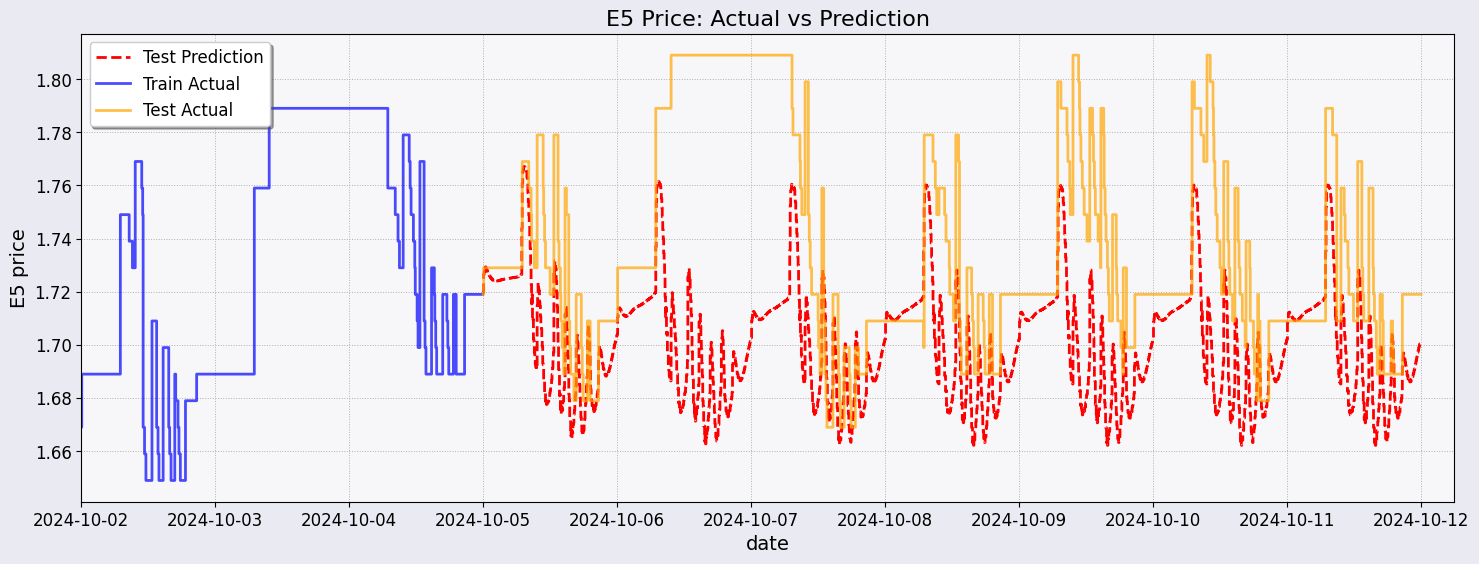

Successfully processed df05

Processing dataset: df06
Error in df06: x must have 2 complete cycles requires 576 observations. x only has 553 observation(s)

Processing dataset: df07


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0168 - val_loss: 0.0056
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 3.8464
1-Day RMSE in cent: 4.7645
1-Day r2-score: -1.8932
3-Day MAE in cent: 4.9861
3-Day RMSE in cent: 5.7050
3-Day r2-score: -2.2303
7-Day MAE in cent: 5.5823
7-Day RMSE in cent: 6.1533
7-Day r2-score: -3.2176


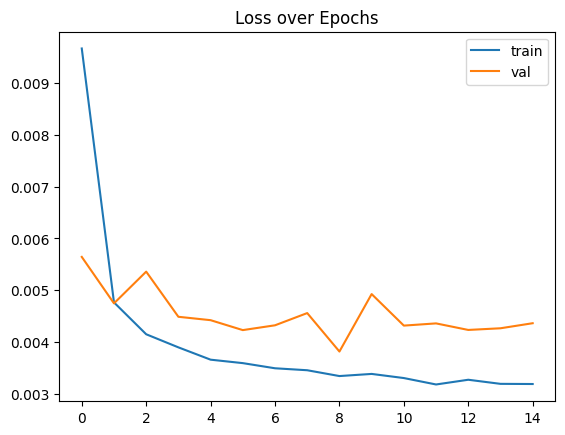

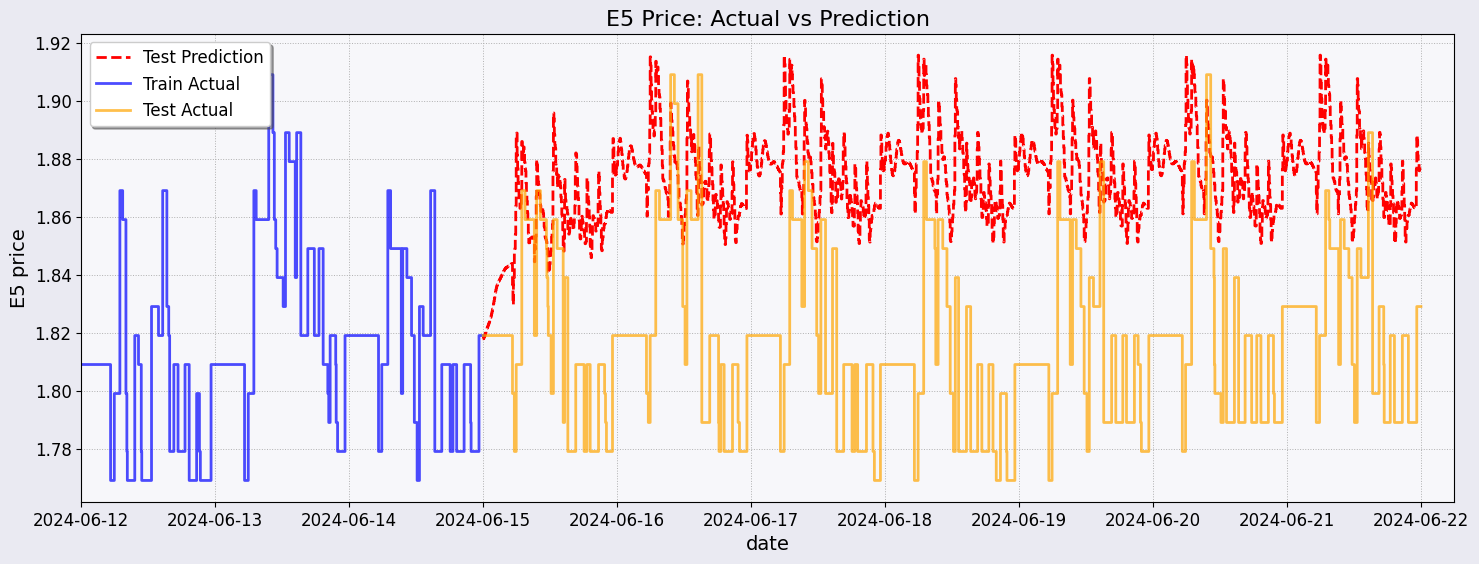

Successfully processed df07

Processing dataset: df08


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0256 - val_loss: 0.0107
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0038 - val_loss: 0.0080
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0030 - val_loss: 0.0065
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0028 - val_loss: 0.0070
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0025 - val_loss: 0.0067
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0022 - val_loss: 0.0059
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0021 - val_loss: 0.0065
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0025 - val_loss: 0.0060
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0023 - val_loss: 0.0055
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0022 - val_loss: 0.0054
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 7.6075
1-Day RMSE in cent: 7.8903
1-Day r2-score: -5.9570
3-Day MAE in cent: 7.9313
3-Day RMSE in cent: 8.2015
3-Day r2-score: -6.2291
7-Day MAE in cent: 7.9227
7-Day RMSE in cent: 8.2493
7-Day r2-score: -4.0904


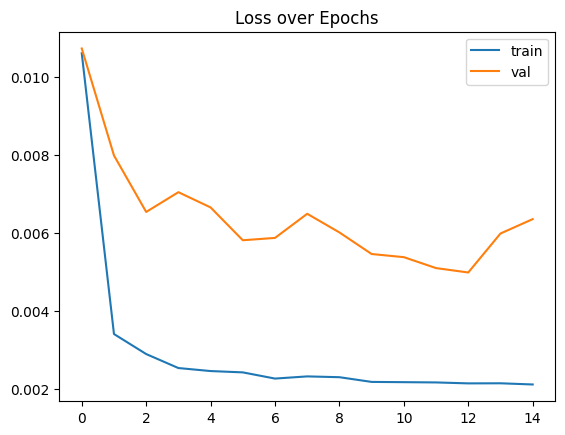

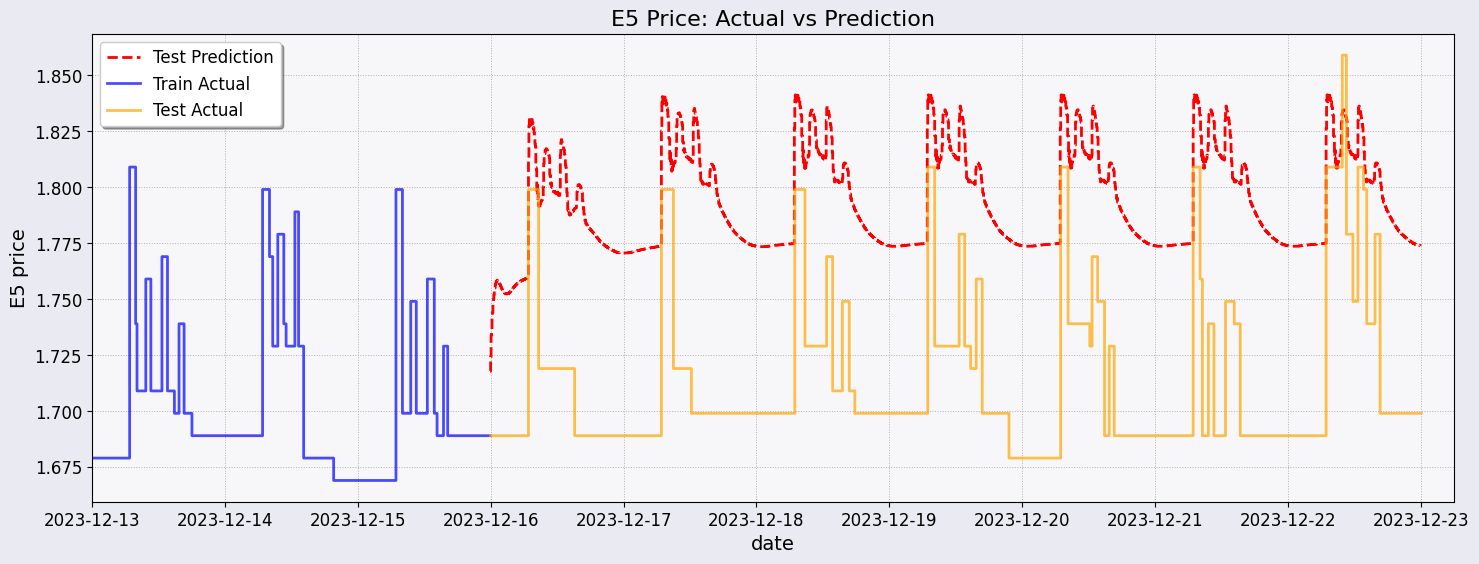

Successfully processed df08

Processing dataset: df09


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0169 - val_loss: 0.0031
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 5.8002
1-Day RMSE in cent: 6.6867
1-Day r2-score: -4.5236
3-Day MAE in cent: 7.1378
3-Day RMSE in cent: 7.7065
3-Day r2-score: -5.9616
7-Day MAE in cent: 6.5949
7-Day RMSE in cent: 7.1278
7-Day r2-score: -5.2457


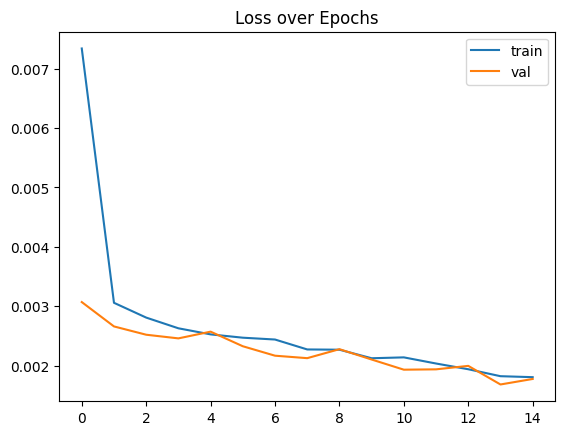

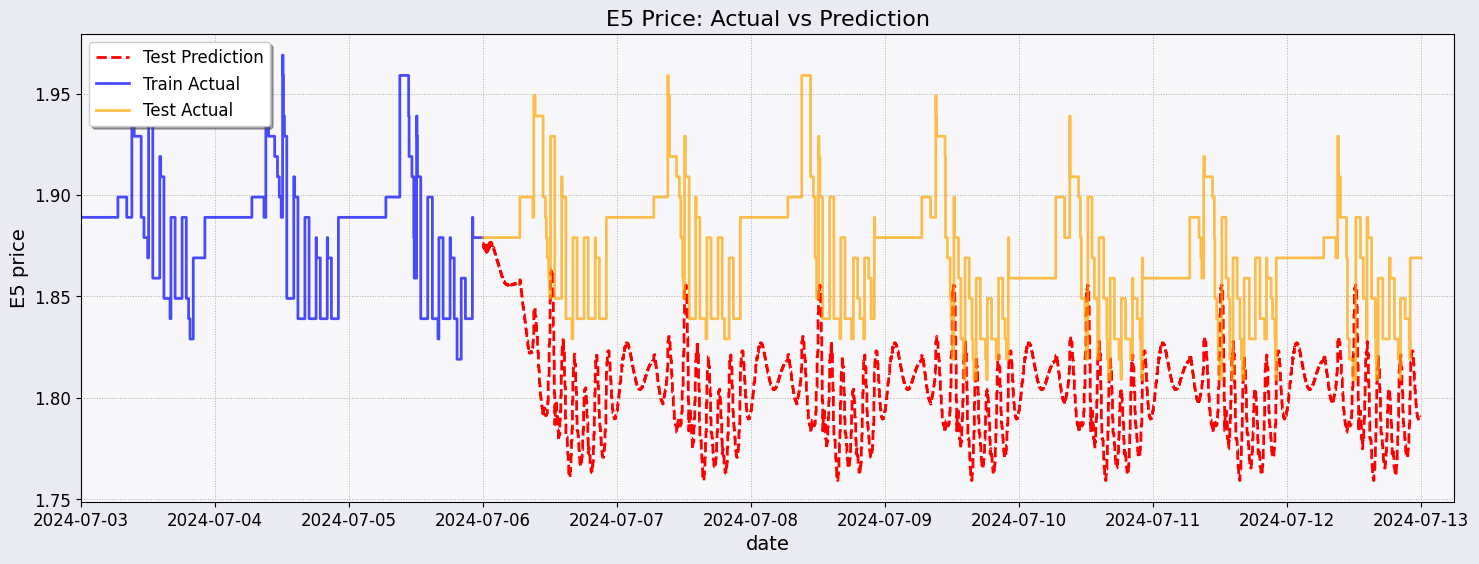

Successfully processed df09

Processing dataset: df10


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0249 - val_loss: 0.0071
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0038 - val_loss: 0.0055
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 5.9142
1-Day RMSE in cent: 6.4457
1-Day r2-score: -4.4346
3-Day MAE in cent: 6.4451
3-Day RMSE in cent: 6.7471
3-Day r2-score: -6.9937
7-Day MAE in cent: 6.6437
7-Day RMSE in cent: 6.9382
7-Day r2-score: -6.4722


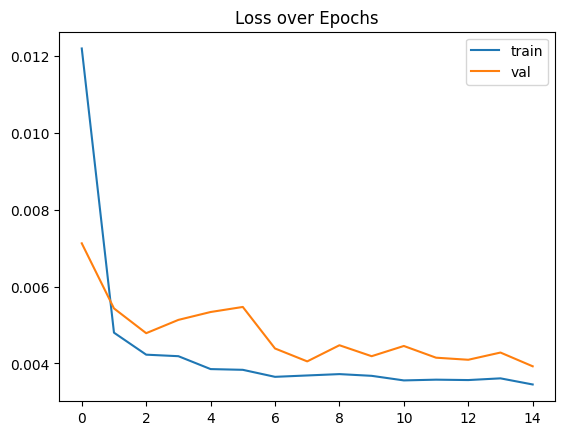

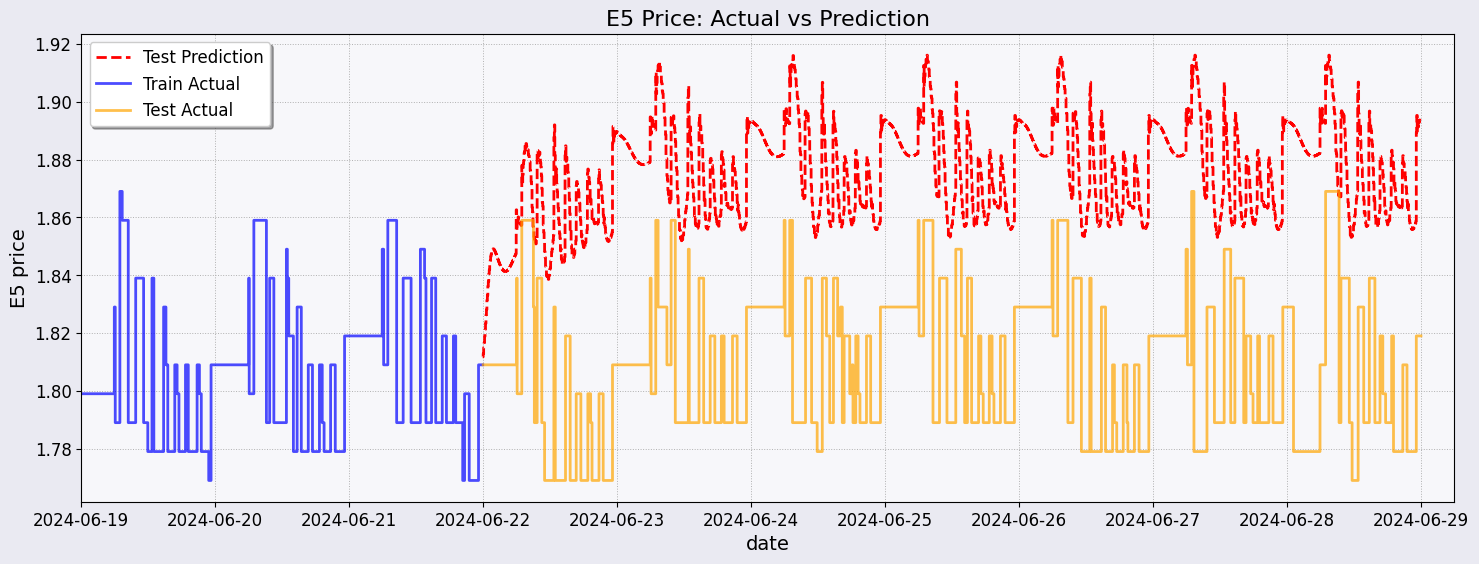

Successfully processed df10

Processing dataset: df11


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0472 - val_loss: 0.0046
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 7.1678
1-Day RMSE in cent: 7.9642
1-Day r2-score: -3.3830
3-Day MAE in cent: 7.4776
3-Day RMSE in cent: 7.9125
3-Day r2-score: -4.2808
7-Day MAE in cent: 6.1069
7-Day RMSE in cent: 7.0513
7-Day r2-score: -1.2577


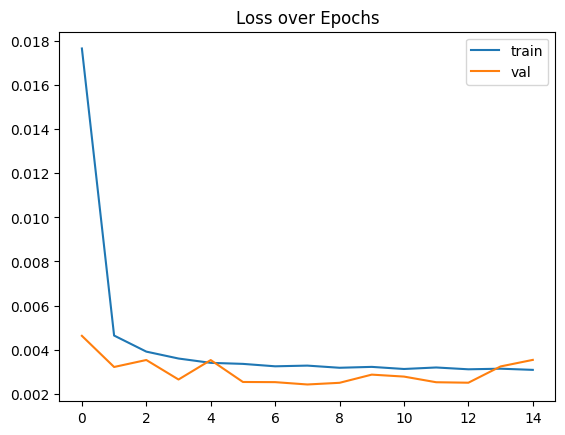

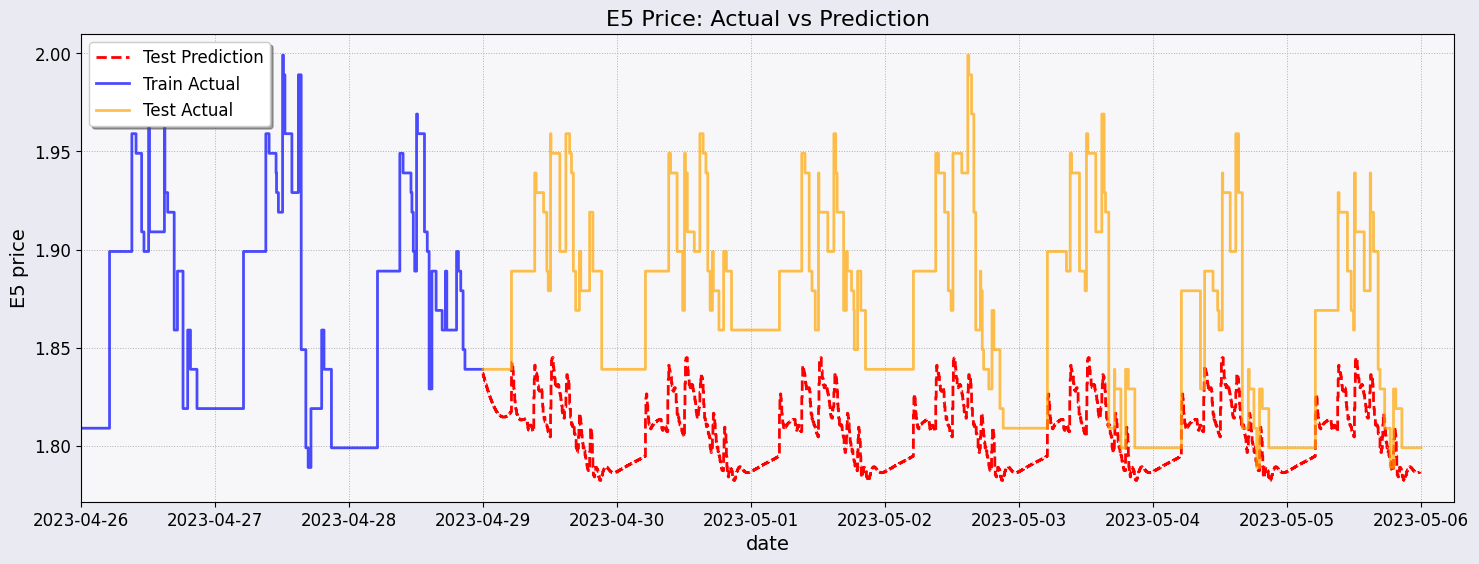

Successfully processed df11

Processing dataset: df12


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0199 - val_loss: 0.0195
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0048 - val_loss: 0.0155
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0041 - val_loss: 0.0078
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0038 - val_loss: 0.0063
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0038 - val_loss: 0.0089
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0035 - val_loss: 0.0088
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0052
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0039 - val_loss: 0.0068
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0034 - val_loss: 0.0085
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0055
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 

1-Day MAE in cent: 5.4283
1-Day RMSE in cent: 6.5408
1-Day r2-score: -2.0711
3-Day MAE in cent: 5.6694
3-Day RMSE in cent: 6.6565
3-Day r2-score: -2.4037
7-Day MAE in cent: 5.6100
7-Day RMSE in cent: 6.3816
7-Day r2-score: -2.9490


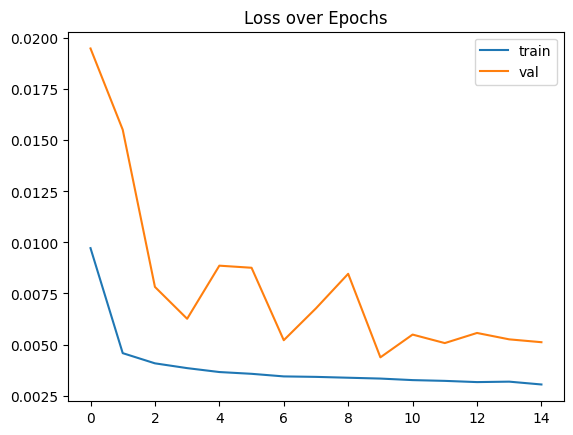

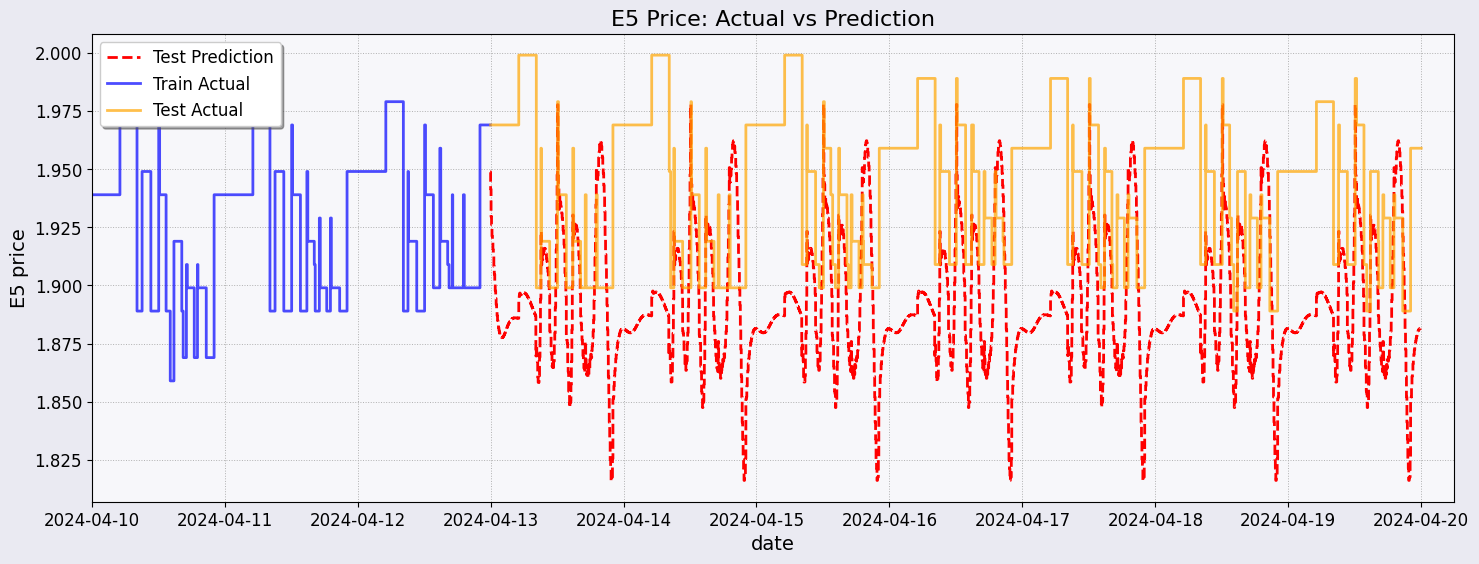

Successfully processed df12

Processing dataset: df13


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0376 - val_loss: 0.0053
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 

1-Day MAE in cent: 3.0610
1-Day RMSE in cent: 3.4534
1-Day r2-score: -0.2424
3-Day MAE in cent: 3.7422
3-Day RMSE in cent: 4.2453
3-Day r2-score: -0.9114
7-Day MAE in cent: 3.9801
7-Day RMSE in cent: 4.6628
7-Day r2-score: -0.9255


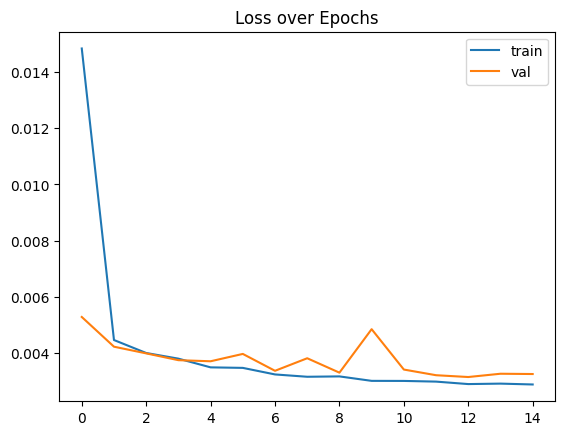

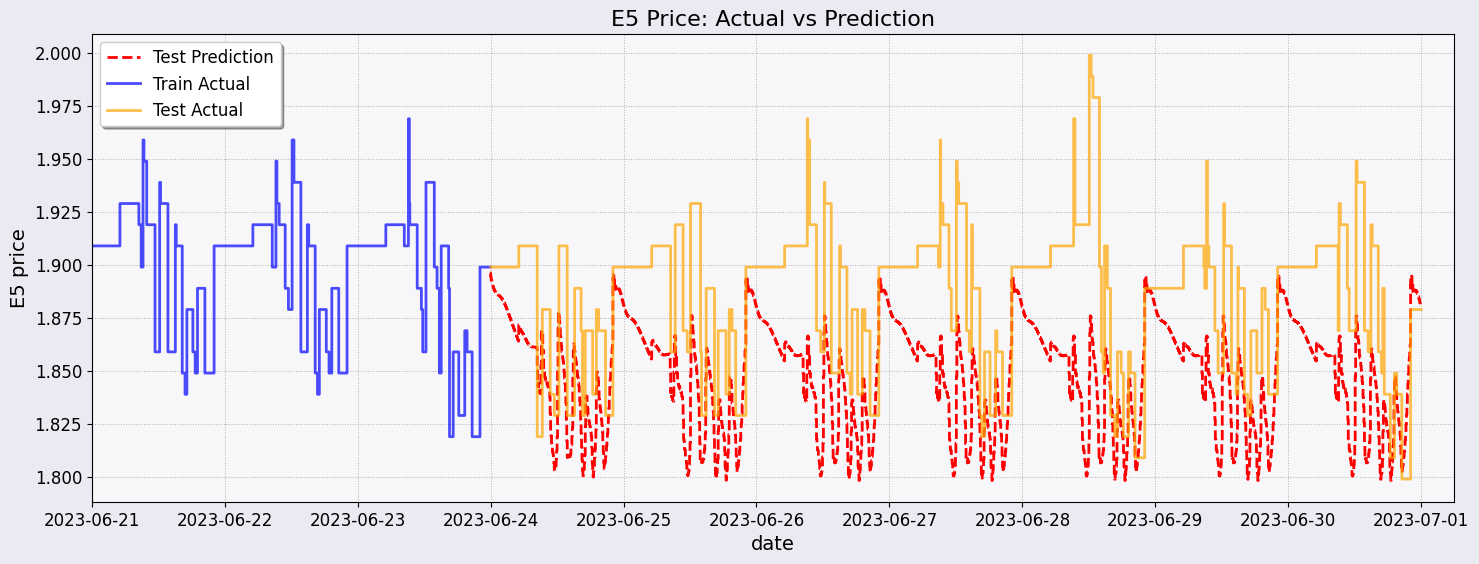

Successfully processed df13

Processing dataset: df14


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0308 - val_loss: 0.0038
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 12.6442
1-Day RMSE in cent: 13.3397
1-Day r2-score: -15.1122
3-Day MAE in cent: 13.4769
3-Day RMSE in cent: 13.8644
3-Day r2-score: -16.6480
7-Day MAE in cent: 14.4143
7-Day RMSE in cent: 14.7694
7-Day r2-score: -15.4259


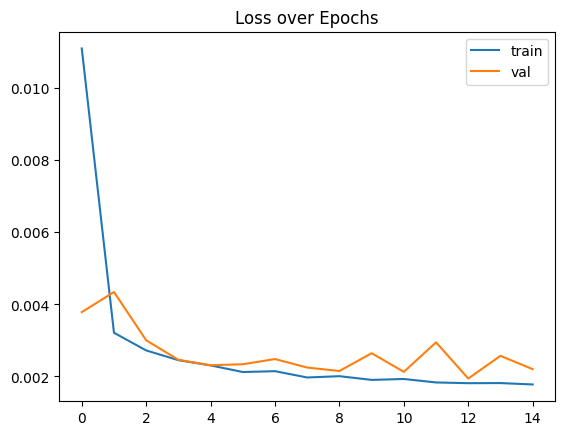

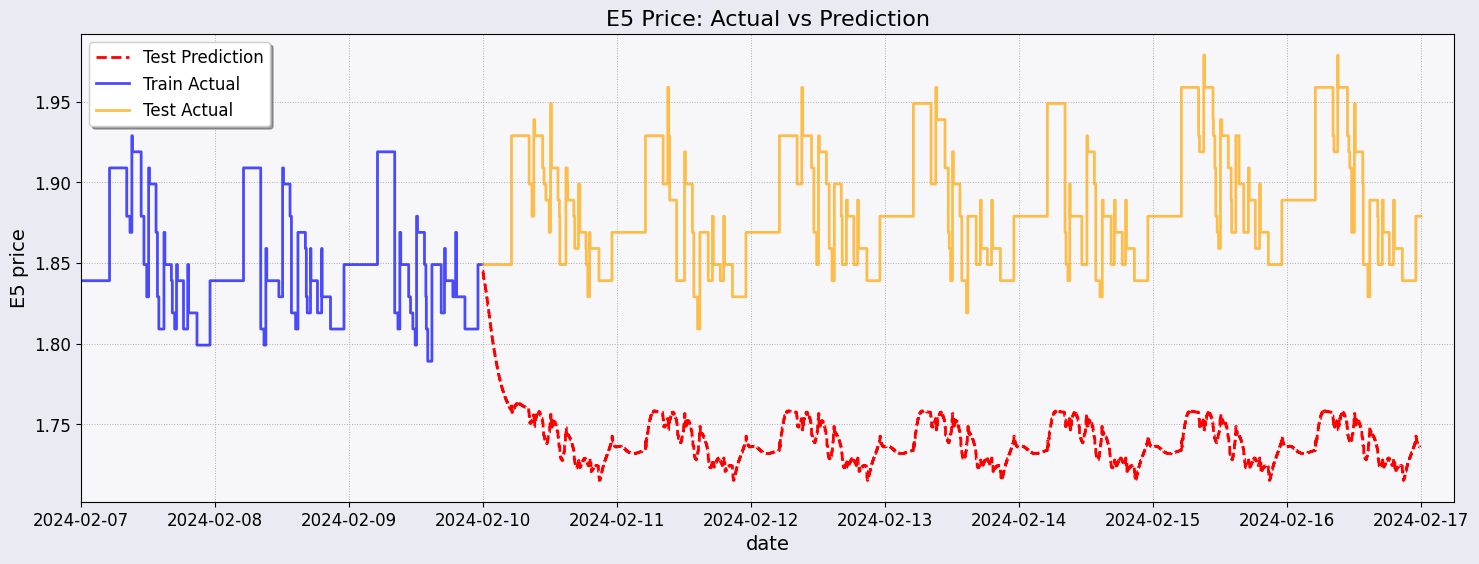

Successfully processed df14

Processing dataset: df15


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0184 - val_loss: 0.0029
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 2.7066
1-Day RMSE in cent: 3.0272
1-Day r2-score: 0.3007
3-Day MAE in cent: 2.8370
3-Day RMSE in cent: 3.1918
3-Day r2-score: 0.4864
7-Day MAE in cent: 3.0776
7-Day RMSE in cent: 3.4171
7-Day r2-score: 0.3323


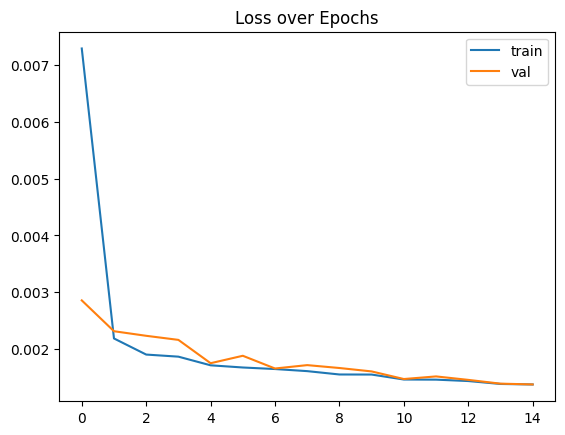

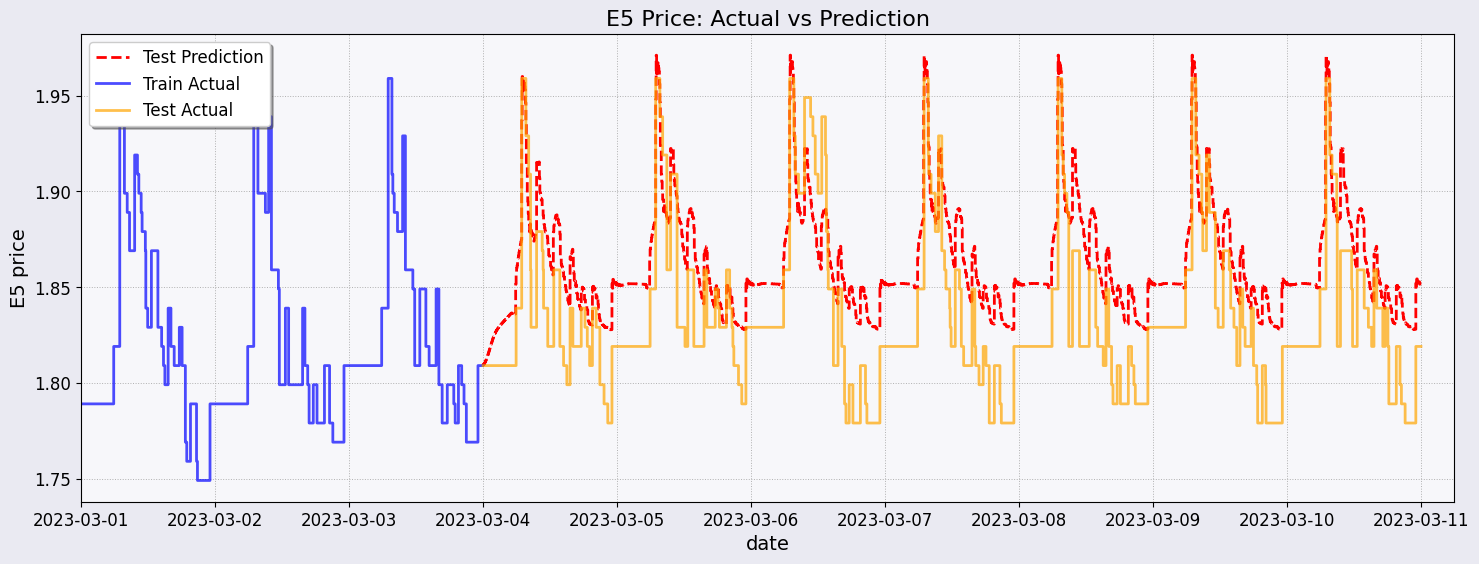

Successfully processed df15

Processing dataset: df16


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0129 - val_loss: 0.0034
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0021 - val_loss: 0.0065
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 7.8702
1-Day RMSE in cent: 8.3976
1-Day r2-score: -6.3776
3-Day MAE in cent: 9.1724
3-Day RMSE in cent: 9.5086
3-Day r2-score: -7.6968
7-Day MAE in cent: 9.9079
7-Day RMSE in cent: 10.2094
7-Day r2-score: -8.8775


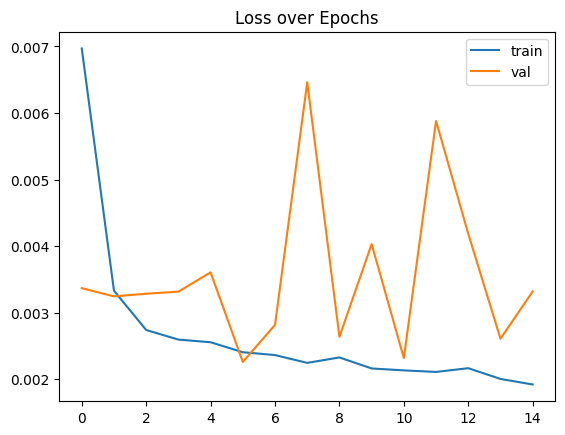

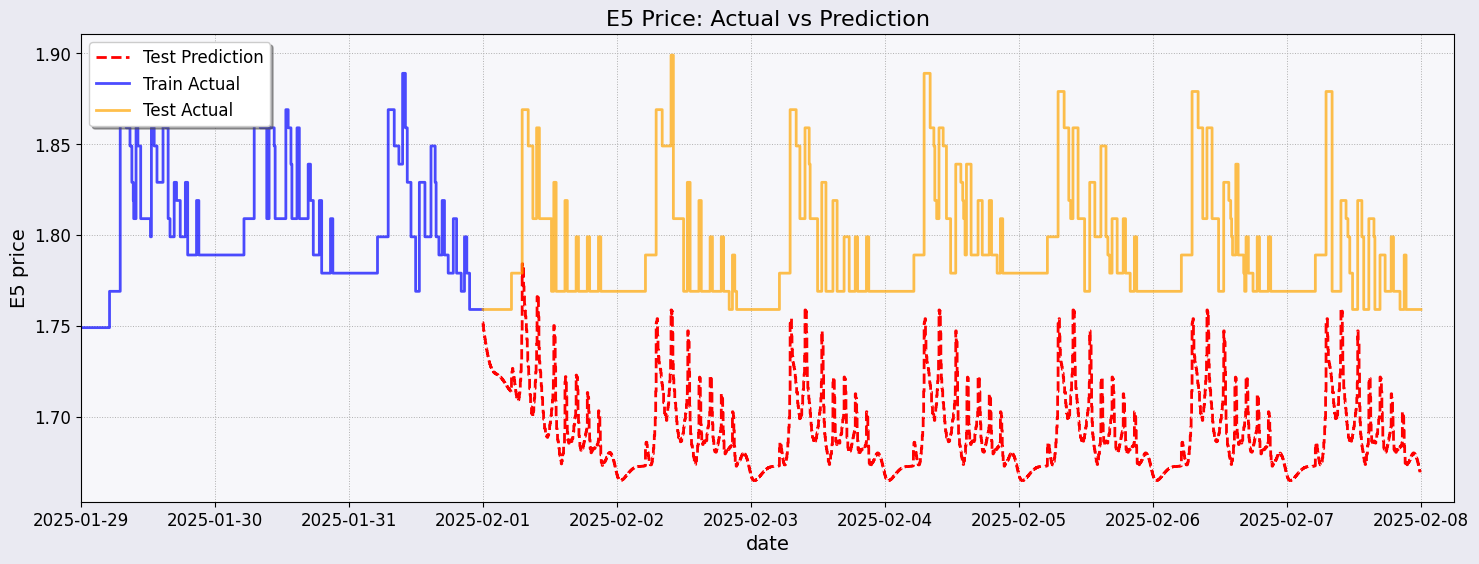

Successfully processed df16

Processing dataset: df17


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0330 - val_loss: 0.0064
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 6.5303
1-Day RMSE in cent: 8.0770
1-Day r2-score: -2.2957
3-Day MAE in cent: 8.7687
3-Day RMSE in cent: 9.5678
3-Day r2-score: -3.6641
7-Day MAE in cent: 10.0932
7-Day RMSE in cent: 10.7112
7-Day r2-score: -4.7019


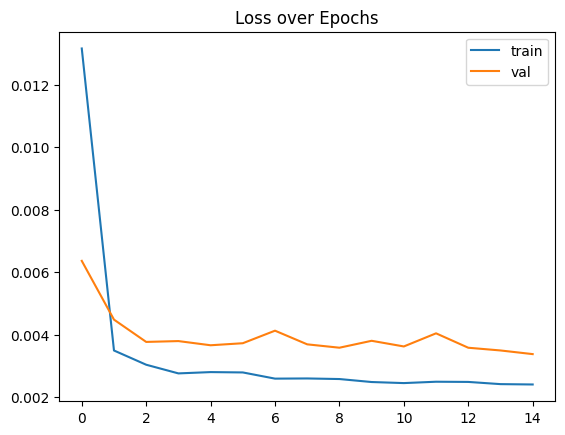

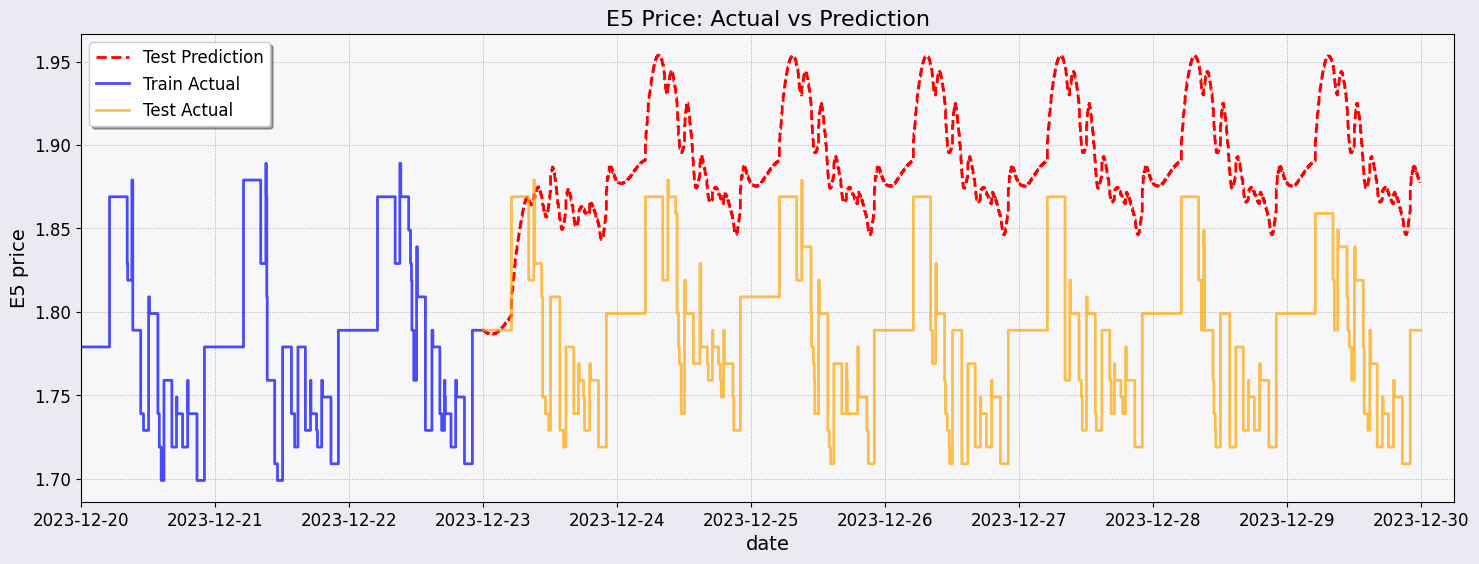

Successfully processed df17

Processing dataset: df18


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0185 - val_loss: 0.0176
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0050 - val_loss: 0.0177
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0045 - val_loss: 0.0149
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0038 - val_loss: 0.0136
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0038 - val_loss: 0.0148
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0039 - val_loss: 0.0151
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0043 - val_loss: 0.0163
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0033 - val_loss: 0.0162
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0037 - val_loss: 0.0200
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0034 - val_loss: 0.0163
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0037 - val_loss: 0.0124
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 7.0113
1-Day RMSE in cent: 8.1261
1-Day r2-score: -5.4048
3-Day MAE in cent: 8.3772
3-Day RMSE in cent: 8.9144
3-Day r2-score: -6.1111
7-Day MAE in cent: 8.8239
7-Day RMSE in cent: 9.2509
7-Day r2-score: -5.4120


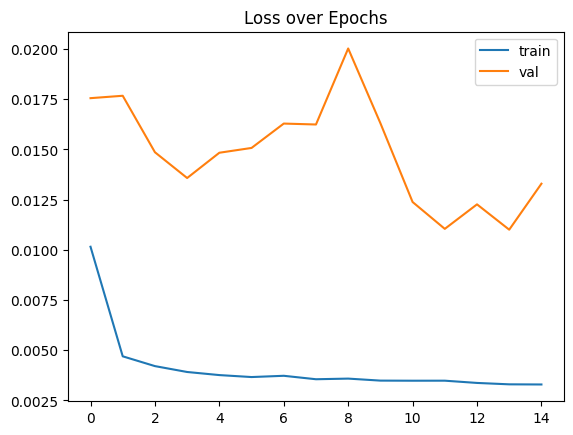

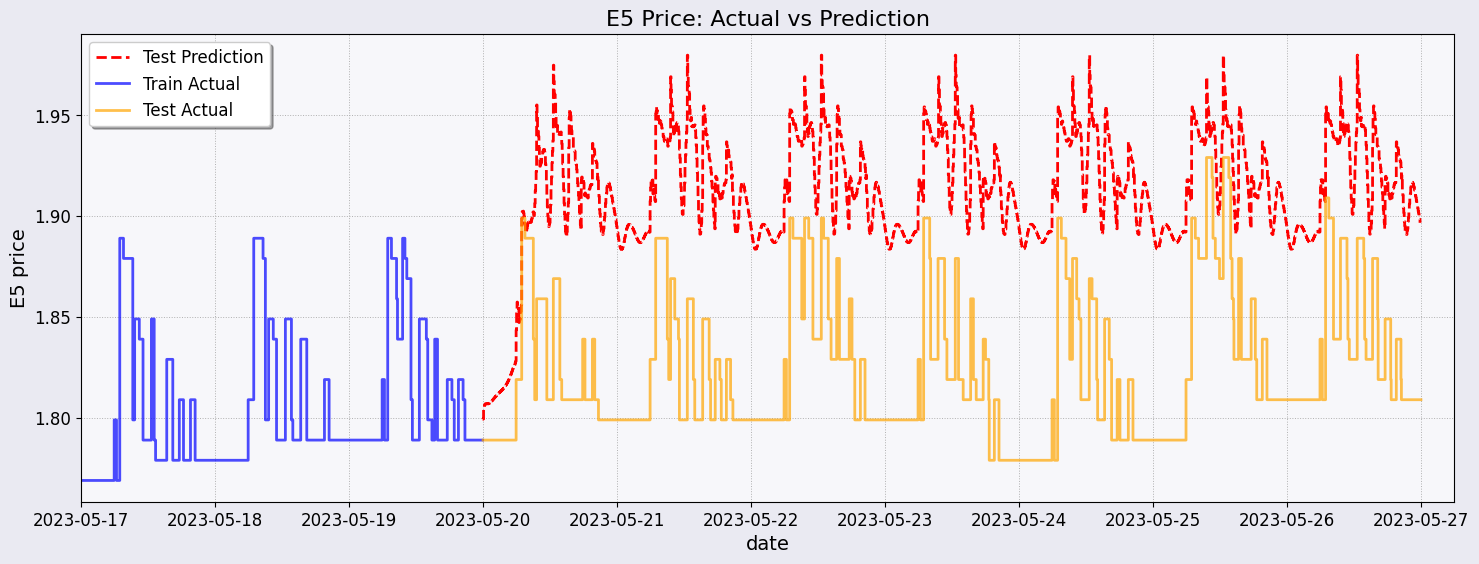

Successfully processed df18

Processing dataset: df19


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0386 - val_loss: 0.0057
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 6.7997e-04 - val_loss: 0.0023
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 3.5342e-04 - val_loss: 9.0692e-04
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 4.3975e-04 - val_loss: 5.6954e-04
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 2.8917e-04 - val_loss: 4.9649e-04
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 2.1634e-04 - val_loss: 3.8933e-04
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 1.8810e-04 - val_loss: 5.9970e-04
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 1.3954e-04 - val_loss: 0.0013
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 3.8711e-04 - val_loss: 5.1352e-04
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 1.9106e-04 - val_loss: 4.3640e-04
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 1.

1-Day MAE in cent: 6.1511
1-Day RMSE in cent: 6.6524
1-Day r2-score: -206.2504
3-Day MAE in cent: 9.3106
3-Day RMSE in cent: 9.6964
3-Day r2-score: -1016.5542
7-Day MAE in cent: 9.8579
7-Day RMSE in cent: 10.0426
7-Day r2-score: -192.0487


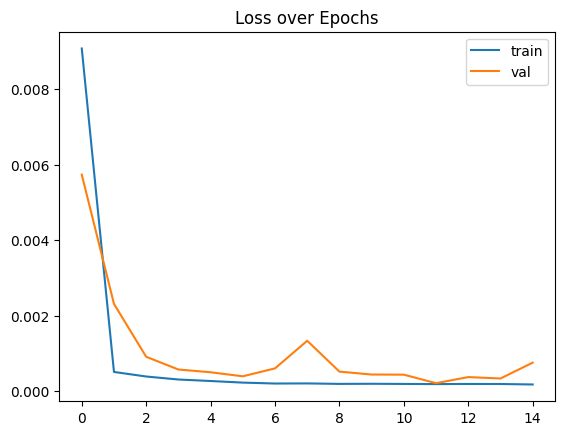

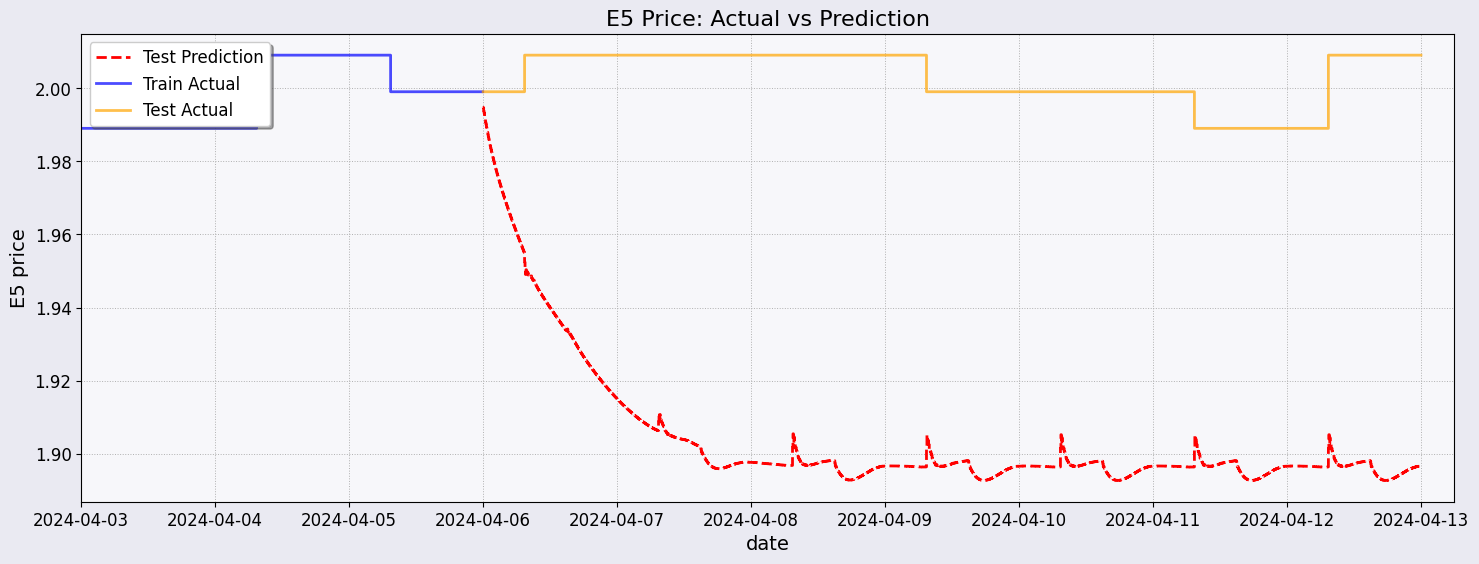

Successfully processed df19

Processing dataset: df20


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms

1-Day MAE in cent: 0.0000
1-Day RMSE in cent: 0.0000
1-Day r2-score: 1.0000
3-Day MAE in cent: 0.0000
3-Day RMSE in cent: 0.0000
3-Day r2-score: 1.0000
7-Day MAE in cent: 0.0000
7-Day RMSE in cent: 0.0000
7-Day r2-score: 1.0000


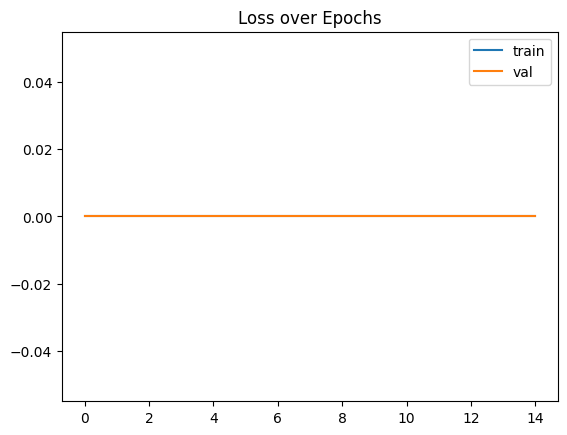

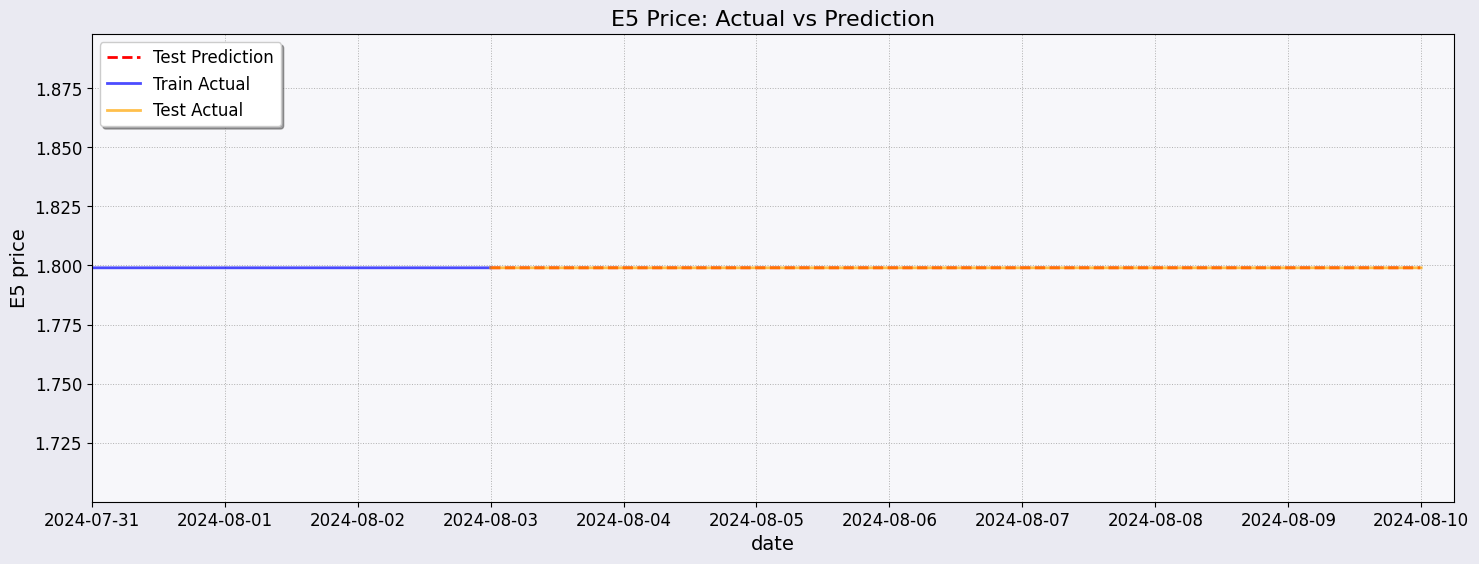

Successfully processed df20

Processing dataset: df21


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0215 - val_loss: 0.0042
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 3.7969
1-Day RMSE in cent: 4.3057
1-Day r2-score: -3.1369
3-Day MAE in cent: 4.0172
3-Day RMSE in cent: 4.4310
3-Day r2-score: -4.0831
7-Day MAE in cent: 4.1563
7-Day RMSE in cent: 4.5279
7-Day r2-score: -4.0321


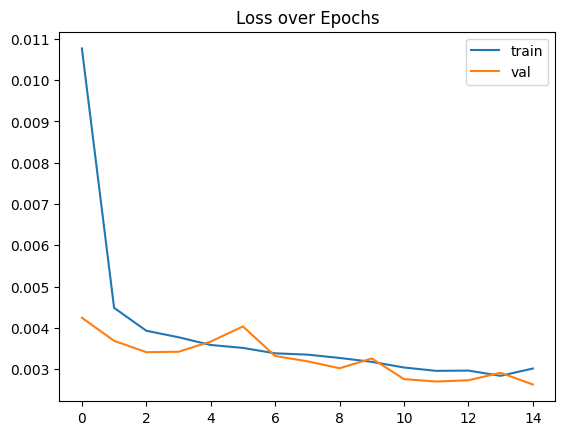

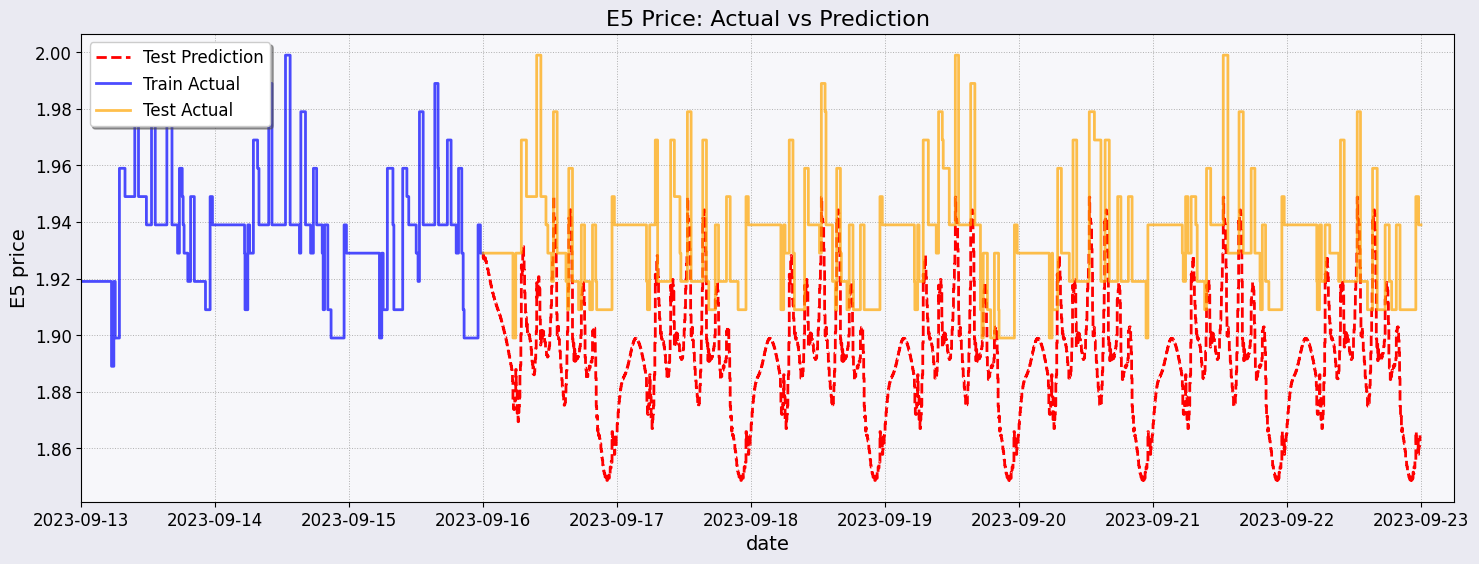

Successfully processed df21

Processing dataset: df22


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0283 - val_loss: 0.0036
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 9.1292
1-Day RMSE in cent: 9.7023
1-Day r2-score: -13.9086
3-Day MAE in cent: 9.9435
3-Day RMSE in cent: 10.5315
3-Day r2-score: -13.5905
7-Day MAE in cent: 10.1599
7-Day RMSE in cent: 10.7871
7-Day r2-score: -11.8502


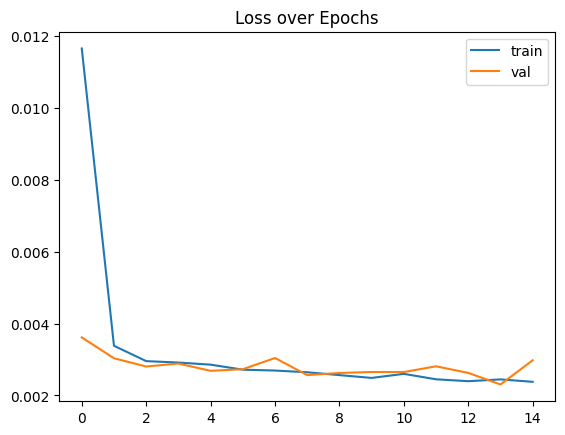

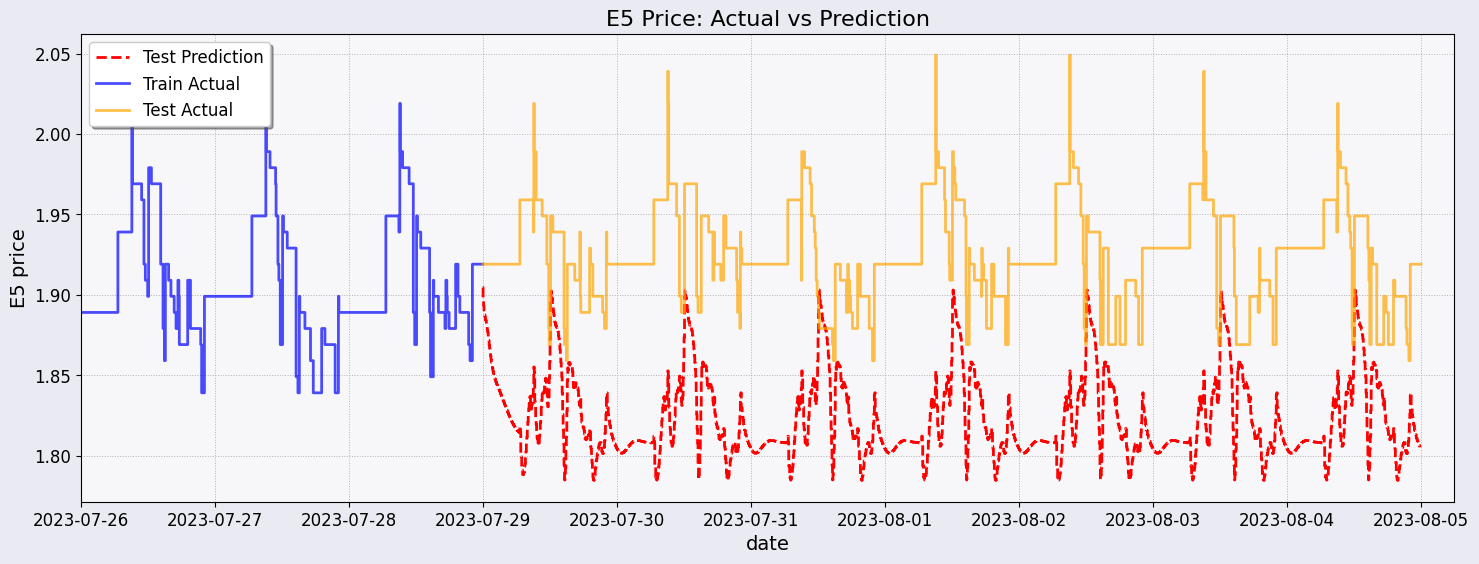

Successfully processed df22

Processing dataset: df23


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0177 - val_loss: 0.0041
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 6.0622
1-Day RMSE in cent: 6.6586
1-Day r2-score: -3.8551
3-Day MAE in cent: 6.8350
3-Day RMSE in cent: 7.3341
3-Day r2-score: -5.3939
7-Day MAE in cent: 6.9779
7-Day RMSE in cent: 7.3895
7-Day r2-score: -5.4541


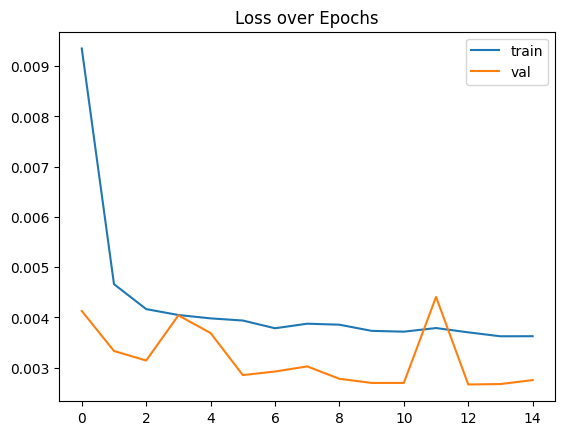

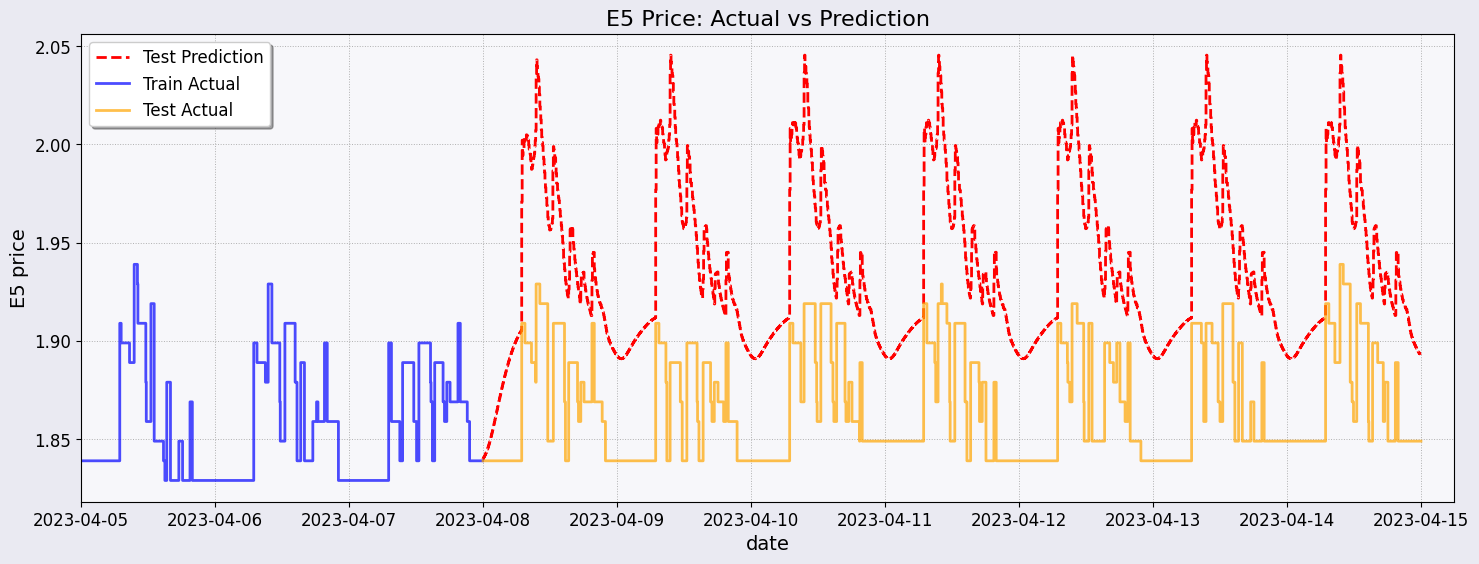

Successfully processed df23

Processing dataset: df24


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0333 - val_loss: 0.0042
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 4.7752
1-Day RMSE in cent: 5.3700
1-Day r2-score: -0.7820
3-Day MAE in cent: 6.2330
3-Day RMSE in cent: 7.2906
3-Day r2-score: -1.7093
7-Day MAE in cent: 4.5827
7-Day RMSE in cent: 5.8642
7-Day r2-score: -0.3168


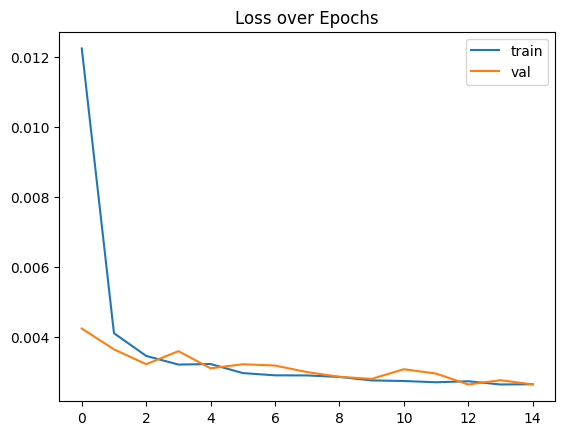

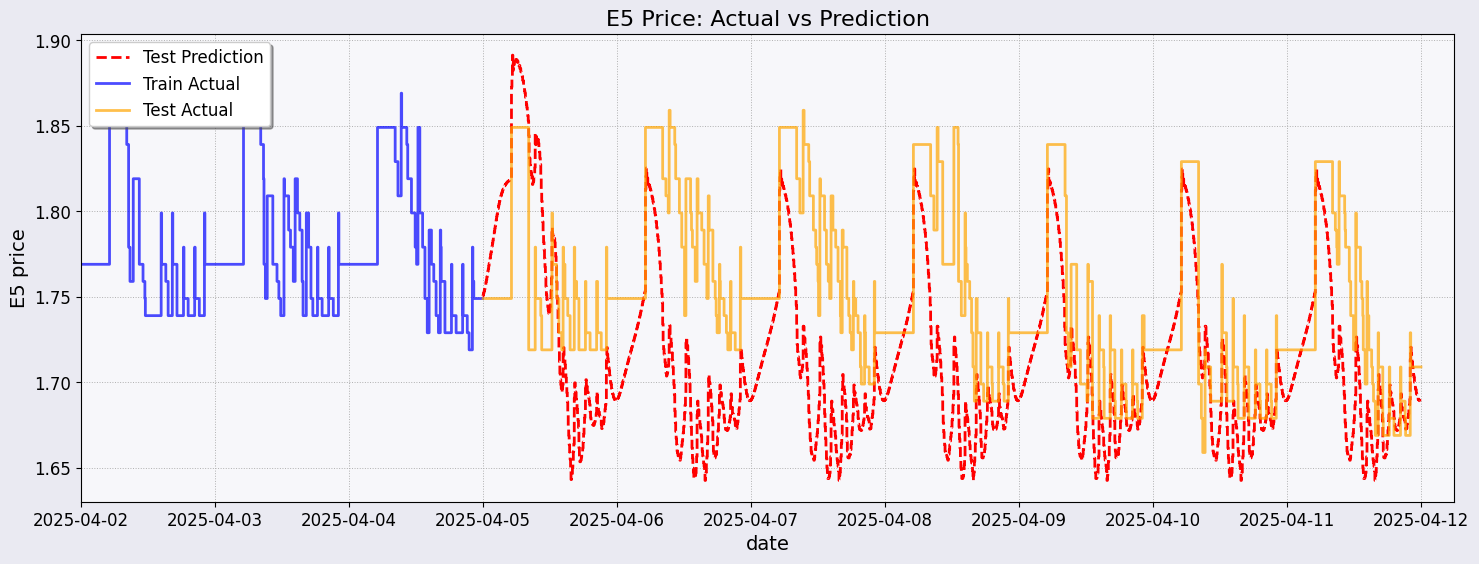

Successfully processed df24

Processing dataset: df25


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0218 - val_loss: 0.0037
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 5.3611
1-Day RMSE in cent: 5.7083
1-Day r2-score: -3.1661
3-Day MAE in cent: 6.0400
3-Day RMSE in cent: 6.3047
3-Day r2-score: -3.2769
7-Day MAE in cent: 6.2800
7-Day RMSE in cent: 6.5278
7-Day r2-score: -3.7526


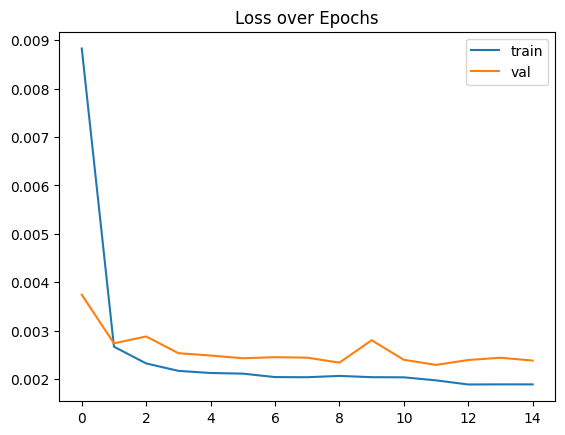

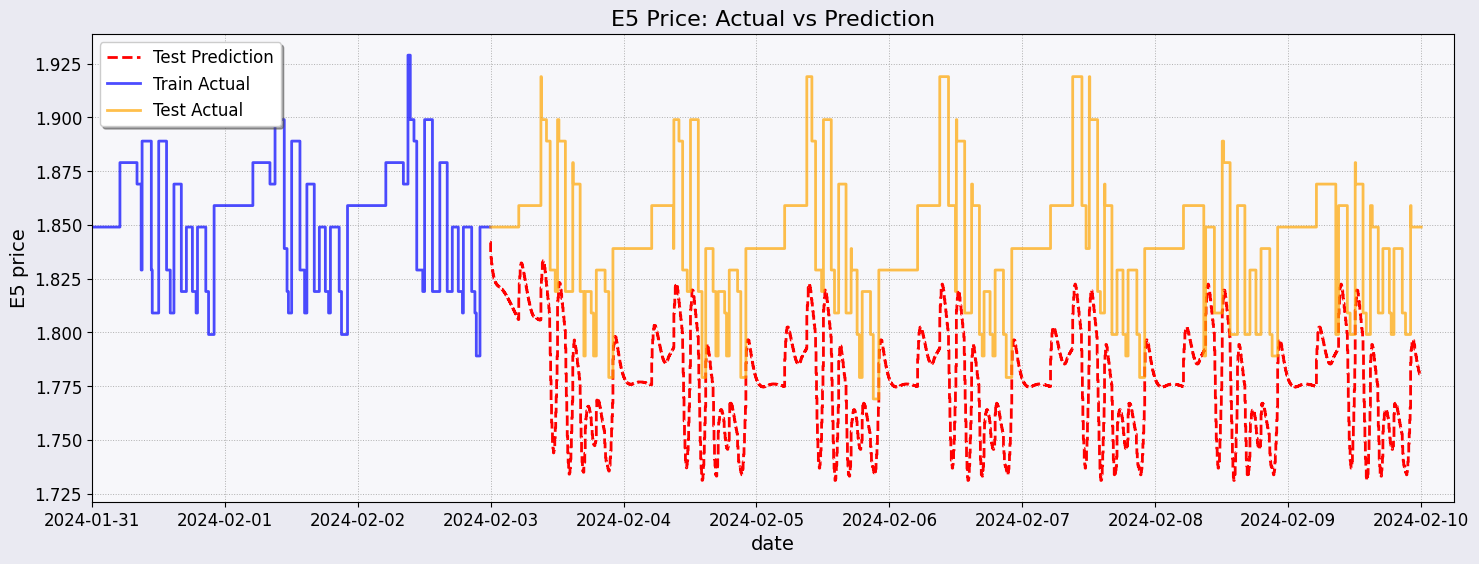

Successfully processed df25

Processing dataset: df26


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0184 - val_loss: 0.0041
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 2.9891
1-Day RMSE in cent: 4.0694
1-Day r2-score: 0.1516
3-Day MAE in cent: 2.8012
3-Day RMSE in cent: 3.8355
3-Day r2-score: 0.2563
7-Day MAE in cent: 2.8878
7-Day RMSE in cent: 3.8226
7-Day r2-score: 0.2192


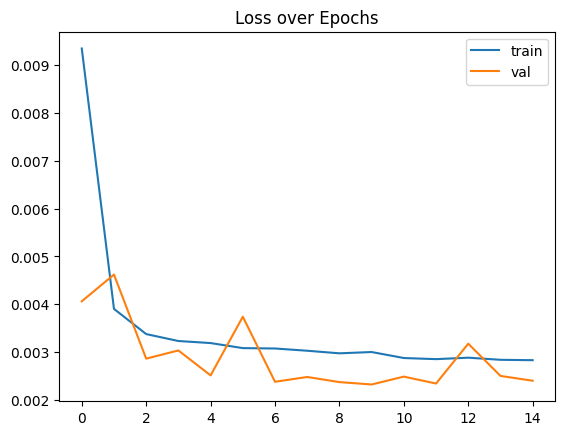

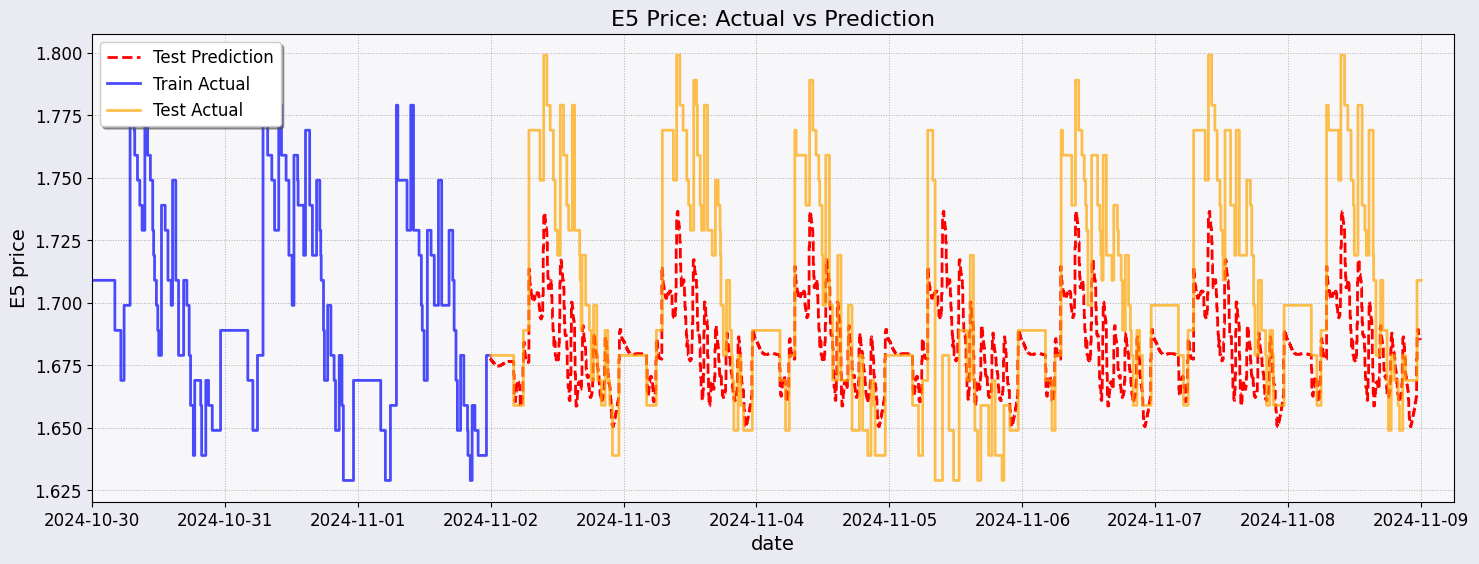

Successfully processed df26

Processing dataset: df27


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0166 - val_loss: 0.0216
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0034 - val_loss: 0.0167
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0032 - val_loss: 0.0173
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0034 - val_loss: 0.0157
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0027 - val_loss: 0.0181
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0027 - val_loss: 0.0204
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0026 - val_loss: 0.0194
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0028 - val_loss: 0.0293
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0027 - val_loss: 0.0199
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0026 - val_loss: 0.0251
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0027 - val_loss: 0.0258
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 6.1809
1-Day RMSE in cent: 6.8303
1-Day r2-score: -2.8640
3-Day MAE in cent: 12.7252
3-Day RMSE in cent: 13.9837
3-Day r2-score: -12.3939
7-Day MAE in cent: 14.4772
7-Day RMSE in cent: 15.3295
7-Day r2-score: -10.5145


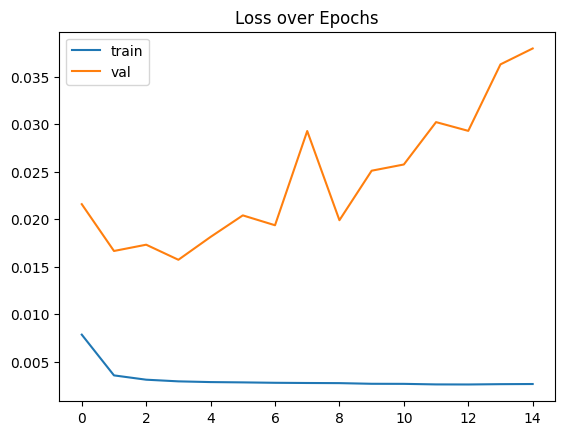

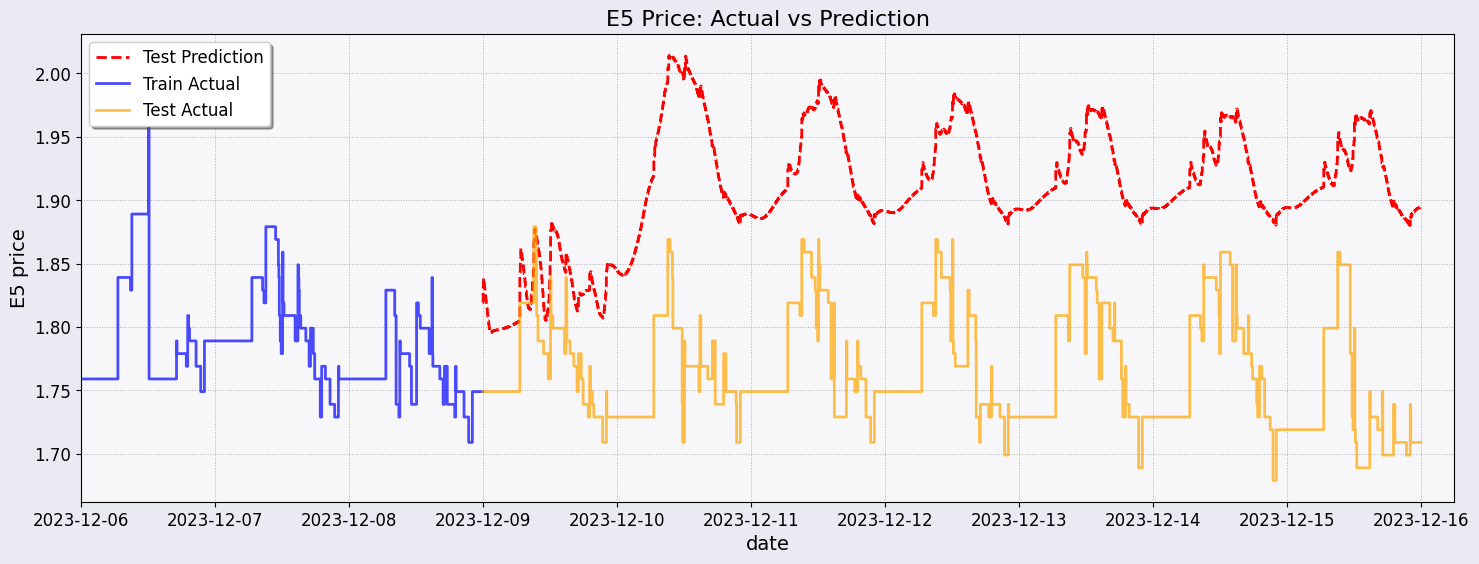

Successfully processed df27

Processing dataset: df28


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0237 - val_loss: 0.0035
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 6.3084
1-Day RMSE in cent: 7.6275
1-Day r2-score: -4.7330
3-Day MAE in cent: 7.1662
3-Day RMSE in cent: 8.0080
3-Day r2-score: -5.3494
7-Day MAE in cent: 6.3038
7-Day RMSE in cent: 7.3490
7-Day r2-score: -2.8253


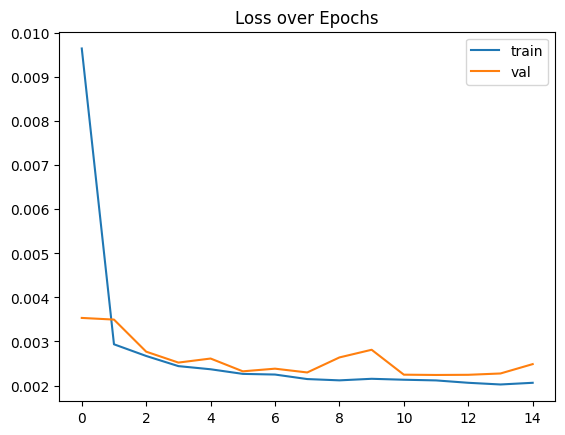

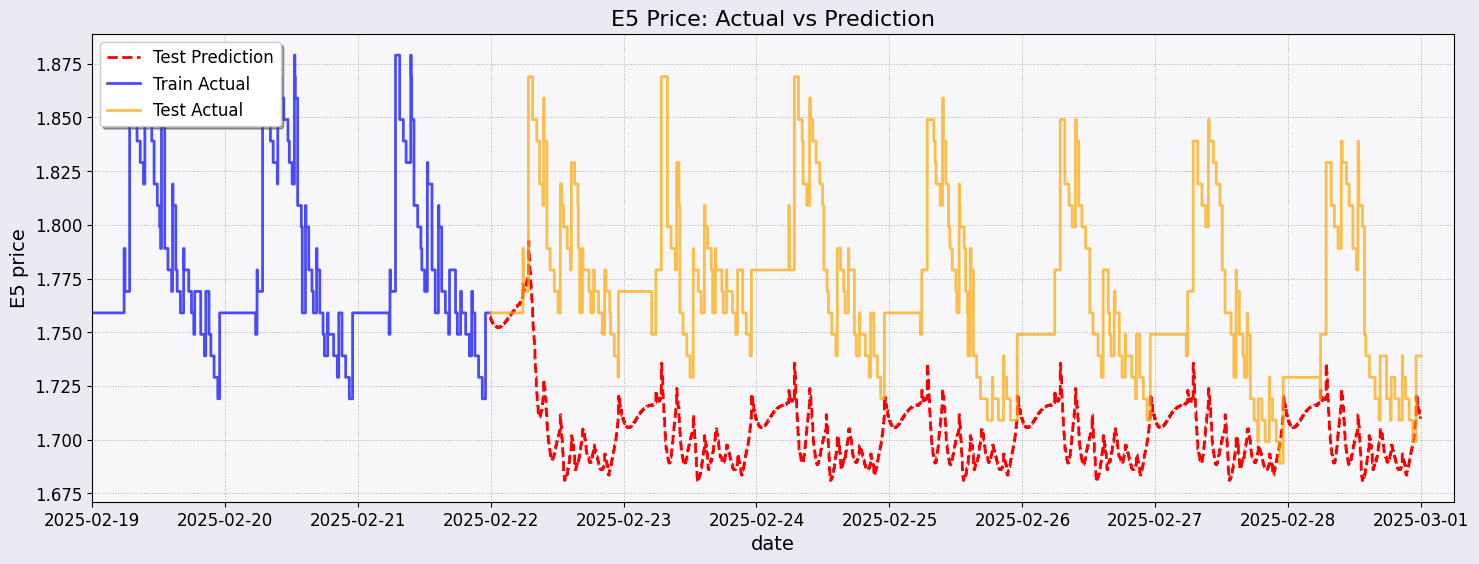

Successfully processed df28

Processing dataset: df29


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0213 - val_loss: 0.0025
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 6.0584
1-Day RMSE in cent: 7.8715
1-Day r2-score: -125670757198607584939663687680.0000
3-Day MAE in cent: 6.8086
3-Day RMSE in cent: 8.3552
3-Day r2-score: -15732244540855553537291059200.0000
7-Day MAE in cent: 7.2655
7-Day RMSE in cent: 8.5631
7-Day r2-score: -9295188406313273730684420096.0000


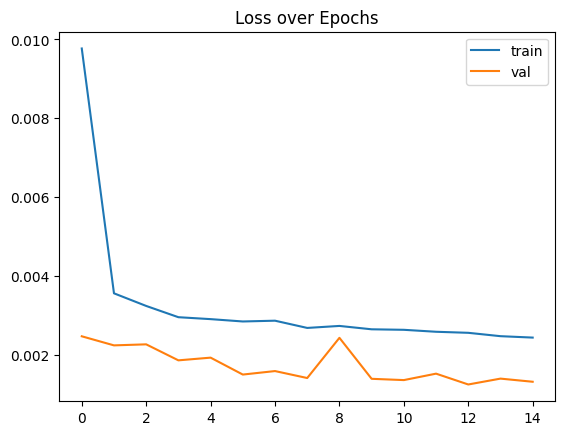

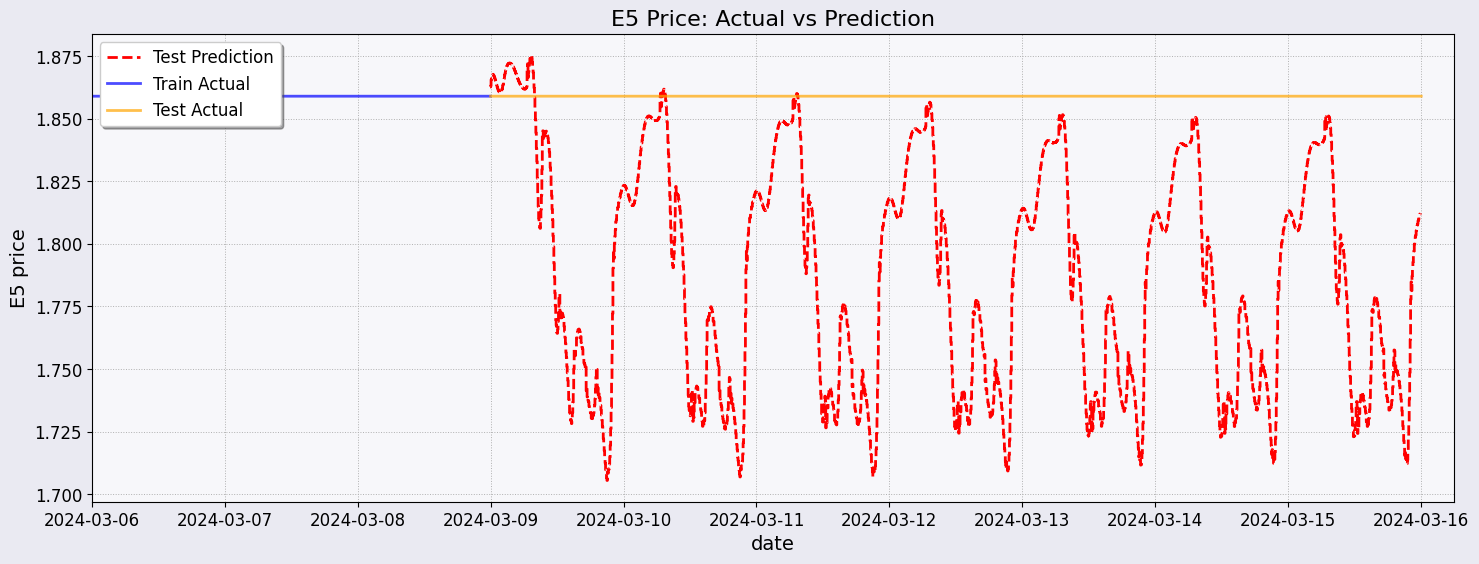

Successfully processed df29

Processing dataset: df30


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0155 - val_loss: 0.0026
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 11/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 12/15
239/239 ━━━━━━━━━━━━━━━━━━

1-Day MAE in cent: 2.2194
1-Day RMSE in cent: 2.6627
1-Day r2-score: 0.0687
3-Day MAE in cent: 2.6208
3-Day RMSE in cent: 3.0809
3-Day r2-score: -0.1006
7-Day MAE in cent: 3.3862
7-Day RMSE in cent: 4.2231
7-Day r2-score: -0.4759


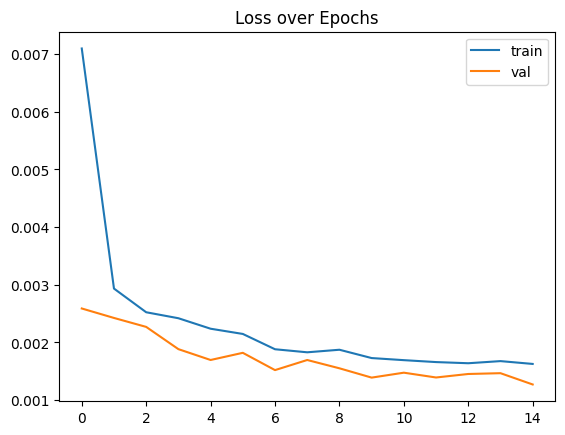

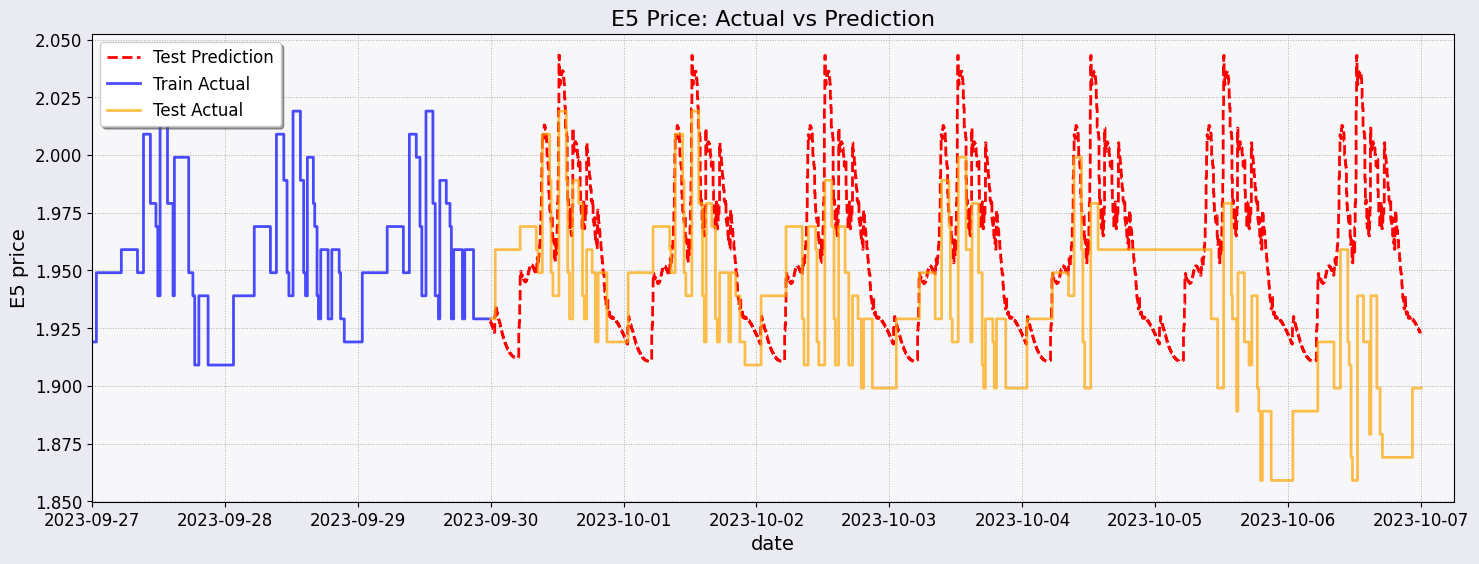

Successfully processed df30

=== Error Summary ===
Total errors: 1

df06:
Error in df06: x must have 2 complete cycles requires 576 observations. x only has 553 observation(s)


In [29]:
forecast_freq = 5 # minutes, discretization between individual values of the forecast
forecast_days = 7 # how many days should be forecasted
train_days = 30 # how many days will be used to train on
sampling_rate = 5 #in minutes, very important parameter

# Create an error log dictionary
error_log = {}

# LOOP
for dataset_name, (df_train, df_test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    try:
        mlflow.end_run()
        
        with mlflow.start_run(run_name=f"fuel_model_cnn_seasonality_{dataset_name}") as run:
            output_days = 7 
            fuel='e5'
            train_start = pd.to_datetime(df_train['datetime'].iloc[-1]) - pd.Timedelta(days = train_days)
            train_end = pd.to_datetime(df_train['datetime'].iloc[-1])
            # The forecast starts immediately after the training data ends
            forecast_start_date = train_end + pd.Timedelta(minutes=forecast_freq)
            # The forecast extends for 'forecast_days' from its start
            forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)

            # PREPROCESSING
            X, y, X_val, y_val, X_forecast, scaler, scaled_train, val_df, test_df = preprocess(
                    df_train=df_train, 
                    df_test=df_test,
                    verbose = False
            )

            # MODELING
            params = {
                'epochs': 15,
                'batch_size': 32,
                'lstm_units': 50
            }

            model_type = 'cnn_lstm_1' # choose between: 'cnn_small', 'cnn_big' and 'cnn_lstm_1'
            
            trained_model, history = train_model_with_mlflow(
                X=X, 
                y=y, 
                X_val=X_val, 
                y_val=y_val,
                model_type=model_type,
                params=params
            )
            val_df_plot = val_df.reset_index()
            train_start = pd.to_datetime(df_train['datetime'].iloc[-1]) - pd.Timedelta(days = train_days)
            val_end = pd.to_datetime(val_df_plot['datetime'].iloc[-1])
            # The forecast starts immediately after the training data ends
            forecast_start_date = val_end + pd.Timedelta(days=1)
            # The forecast extends for 'forecast_days' from its start
            forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)
            train_plot_start = pd.to_datetime(df_train['datetime'].iloc[-1]) - pd.Timedelta(days = 2)
            train_plot_end = pd.to_datetime(df_train['datetime'].iloc[-1]) + pd.Timedelta(days = 1)
            train_dates_plot = (pd.to_datetime(train_plot_start.strftime('%Y-%m-%d')), pd.to_datetime(train_plot_end.strftime('%Y-%m-%d')))
            test_dates_plot = pd.to_datetime(forecast_start_date.strftime('%Y-%m-%d')), pd.to_datetime(forecast_end_date.strftime('%Y-%m-%d'))+ pd.Timedelta(days = 1.25)

            # FORECASTING
            y_pred_df = forecasting(X_forecast, scaled_train, scaler, fuel='e5', model = trained_model, output_days=output_days, forecast_start_date=forecast_start_date)

            # reset index before plotting
            df_train_plot = df_train.reset_index()
            df_test_plot = df_test.reset_index()
            y_pred_df_plot = y_pred_df.reset_index()
            
            # Plot
            mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day = plot_forecast(
                df_train=df_train_plot,
                df_test=df_test_plot,
                station_uuid=None,
                df_train_prediction=None,
                df_test_prediction=y_pred_df_plot,
                train_dates=train_dates_plot,
                test_dates=test_dates_plot,
                train_dates_plot=train_dates_plot,
                test_dates_plot=test_dates_plot
            )
            mlflow.log_artifact("prediction.png")
            mlflow.log_metrics({
            "mae_1_day": mae_1_day,
            "mae_3_day": mae_3_day,
            "mae_7_day": mae_7_day,
            "rmse_1_day": rmse_1_day,
            "rmse_3_day": rmse_3_day,
            "rmse_7_day": rmse_7_day,
            "r2_1_day": r2_1_day,
            "r2_3_day": r2_3_day,
            "r2_7_day": r2_7_day
            })
        print(f"Successfully processed {dataset_name}")
        
    except Exception as e:
        # Log the error and continue with next dataset
        error_message = f"Error in {dataset_name}: {str(e)}"
        error_log[dataset_name] = error_message
        print(error_message)
        
        # Make sure to end the MLflow run if it failed
        mlflow.end_run()
        continue

# After the loop, print summary of errors
print("\n=== Error Summary ===")
if error_log:
    print(f"Total errors: {len(error_log)}")
    for dataset, error in error_log.items():
        print(f"\n{dataset}:")
        print(error)
else:
    print("All datasets processed successfully!")

=== Error Summary ===
Total errors: 2

df06:
Error in df06: x must have 2 complete cycles requires 576 observations. x only has 552 observation(s)

df20:
Error in df20: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

# Checking your data with MLFlow:
Start the MLFlow by entering "mlflow ui" into the Terminal and opening the given uri in your browser.
To abort MLflow again, go to terminal and press "ctrl+c".

In [30]:
%mlflow ui --backend-store-uri file:data/mlflow

UsageError: Line magic function `%mlflow` not found.
